<a href="https://colab.research.google.com/github/Basa0006/Excel_Work/blob/main/PartsConsumptionReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

#####The idea behind this is to run a parts consumption report for a customer or multiple customers and automatically generate a parts usage report, detailing where most of their parts are being consumed and by what.  It will also produce top ten parts purchased by dollar amount for each facility in all categories, misc. catogory, and other category.  Lastly, it will predict the projected spend based on ytd spend and give a replacement cost of all equipment based on projected annual spend at 3% of replacment cost.  Then it generates a powerpoint presentation to share the information in a simple manner.

#Install packages

In [ ]:
!pip install openpyxl xlsxwriter

In [ ]:
!pip install python-pptx

#Import Libraries

In [ ]:
# @title
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import os
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor
from pptx.enum.text import PP_ALIGN

import inspect
from openpyxl import load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.utils import get_column_letter
from openpyxl.styles import numbers

from datetime import datetime

import io
from PIL import Image, ImageDraw, ImageFont
import textwrap
import sys

#Functions

In [ ]:
#function to save print statements to png file for powerpoint presentation.


def print_to_png(print_function, filename='output.png', font_path=None, font_size=34, width=500):
    # Capture stdout
    buffer = io.StringIO()
    sys.stdout = buffer
    print_function()
    sys.stdout = sys.__stdout__
    text = buffer.getvalue()

    # Load font
    if font_path:
        font = ImageFont.truetype(font_path, font_size)
    else:
        font = ImageFont.load_default()

    # Split text by lines
    lines = text.strip().split('\n')
    if not lines:
        lines = ["(no output)"]

    # Get line height
    bbox = font.getbbox("A")
    line_height = bbox[3] - bbox[1] + 6  # line height + padding
    height = line_height * (len(lines) + 2)

    # Create image
    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    # Draw lines
    y = 10
    for line in lines:
        draw.text((10, y), line, fill="black", font=font)
        y += line_height

    img.save(filename)
    print(f"Saved print output to {filename}")

In [ ]:
from datetime import datetime

def get_day_of_year(timestamp):
    # Ensure the input is a datetime object
    if isinstance(timestamp, str):
        timestamp = datetime.fromisoformat(timestamp)
    return timestamp.timetuple().tm_yday

In [ ]:
#function to save dataframe as excel table
def save_df_as_excel_table_auto(df, df_name: str, sheet_name='Sheet1', table_name='Table1'):
    file_path = f'/content/{df_name}.xlsx'

    # Save DataFrame to Excel
    df.to_excel(file_path, index=False, sheet_name=sheet_name)

    # Load workbook and worksheet
    wb = load_workbook(file_path)
    ws = wb[sheet_name]

    # Get number of rows and columns including header
    max_row = df.shape[0] + 1  # +1 for header row
    max_col = df.shape[1]

    # Define table range (starts at A1, ends at bottom-right cell)
    end_col_letter = get_column_letter(max_col)
    table_range = f"A1:{end_col_letter}{max_row}"

    # Create and style the table
    table = Table(displayName=table_name, ref=table_range)
    style = TableStyleInfo(
        name="TableStyleMedium9",
        showFirstColumn=False,
        showLastColumn=False,
        showRowStripes=True,
        showColumnStripes=False
    )
    table.tableStyleInfo = style
    ws.add_table(table)

    # Auto-fit column widths
    for col_cells in ws.columns:
        max_length = 0
        column = col_cells[0].column_letter
        for cell in col_cells:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        ws.column_dimensions[column].width = max_length + 2

    # Save final file
    wb.save(file_path)
    print(f"✅ Excel file saved to: {file_path}")


#Pre-Processing Data

In [ ]:
#import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel("/content/Compiled.xlsx", sheet_name='Data')

df.head()






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Supplier Ship Via Transit Description,Delivery Terms,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description
0,P24108,5,2,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,SKID AND CRATE,...,NaN,FOB,FOB ORIGIN FRT PREPAID & ADD,0,NaN,IA,NaN,ITEM NOT EXCHANGED,NaN,NaN
1,P24108,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-1,PALLET RETRACT VAT DUMPER,...,NaN,FOB,FOB ORIGIN FRT PREPAID & ADD,0,NaN,IA,NaN,ITEM NOT EXCHANGED,NaN,NaN
2,P24108,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-2,PALLET RETRACT VAT DUMPER,...,NaN,FOB,FOB ORIGIN FRT PREPAID & ADD,0,NaN,IA,NaN,ITEM NOT EXCHANGED,NaN,NaN
3,P24108,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-3,PALLET RETRACT VAT DUMPER,...,NaN,FOB,FOB ORIGIN FRT PREPAID & ADD,0,NaN,IA,NaN,ITEM NOT EXCHANGED,NaN,NaN
4,P24108,5,1,Cancelled,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,SKID AND CRATE,...,NaN,FOB,FOB ORIGIN FRT PREPAID & ADD,0,NaN,IA,NaN,ITEM NOT EXCHANGED,NaN,NaN


In [ ]:
#%%script echo skipping
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Columns: 129 entries, Order No to Cancellation Reason Description
dtypes: bool(3), datetime64[ns](8), float64(48), int64(26), object(44)
memory usage: 718.9+ KB


In [ ]:
#break out part number and remove first two digits.  Then use these digits and dfcategory table to create category

# Create a new column with the first two digits of the part number

df['Category Code'] = df['Sales Part No'].str[:2]

#df.head(100).sample(n=10)



In [ ]:
# Create a dataframe correlating category code with category
dfcategorycodes = pd.DataFrame({
    'Category Code': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20', '21',
    '95','96','97','98','EK','EP','ET','EM','DF'],
    'Category': ['Stainless Steel', 'Electrical','Mechanical','Hydraulic','Pneumatic','Vacuum','Misc','Water', 'Steam', 'Refrigerant', 'Pipe & Tube Fittings',
                 'Seals & Gaskets', 'Plastic', 'Misc. Metal','Safety Stickers', 'Lubricants', 'Manuals', 'Shop & Office Supplies', 'Grating', 'Scale Systems', 'Belting Material',
                 'Design Assemblies','Design Piping & Valves','Electrical Assemblies','Manufactured Parts','Mill','Mill',
                 'Mill','Mill','Danfotech']
})

#Need to define what SP falls into

#merge two data frames together
df = df.merge(dfcategorycodes, on='Category Code', how='left')

# Replace NaNs with 'Other'
df.fillna('Other', inplace=True)
df.head(100).sample(n=10)


/tmp/ipython-input-250-1138641139.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Other' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna('Other', inplace=True)
/tmp/ipython-input-250-1138641139.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Other', inplace=True)


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category
98,A259983,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,SS308V13B,SEAL HOUSING-FEED SCREW,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,SS,Other
43,P24138,6,5,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,CRATING,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other
6,A259336,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-30120200-11,Level control HMFB-OT,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
34,P24138,10,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P25079-CVD626-1,PALLET RETRACT VAT DUMPER,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,P2,Other
47,P24138,6,6,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,SERVO STUFFING HOPPER 2000#,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other
72,A259526,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50040,"O-RING,SHAFT SEAL, UNIBLOC 500",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc
66,A259395,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-53151046,Cylinder f sidepress 1228-AD-90/50x,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
48,P24138,6,7,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,INSTALL START UP TECHNICIAN,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other
31,A259824,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,EM-1037,SEAL INSERTION TOOL AR901,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,EM,Mill
24,A259667,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,EMM-9016,SPACER ASSEMBLY W/PINS,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,EM,Mill


In [ ]:
#if Order No is P*****, then make Category Capital
# Update the 'Category' column while keeping unchanged values for non-'P' orders
df["Category"] = df.apply(lambda row: "Capital" if row["Order No"].startswith("P") else row["Category"], axis=1)

#display all projects
#df[df['Category'] == 'Capital']

df.head(1500).sample(n=20)


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category
478,A262193,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,EK-1048-50,MACHINE KNIFE INSER/EACH/50PACK 901,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,EK,Mill
552,A262339,33,1,Reserved,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-30516828-150,"Hydr. hose No.40, Log Press 8-35",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
192,A260169,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-30976500,"screw-joint, straight GE 15 LR 1/2",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
579,A262339,58,1,Released,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-53351030-65,"GATE, LEFT",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
467,A262087,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-30516800,"Hydr. hose No. 25, Bacon Press 6",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
312,A261283,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50057,"SEAL HSG, O-RING, UNIBLOC",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc
279,A261069,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-30355190,"Cylinder 1228-SD-50/36x200-S, Sidep",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
554,A262339,38,1,Reserved,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DF-53151150,"Shaft, ø30x60",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
184,A260434,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,11-005-0113,"GASKET 12""",...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,11,Pipe & Tube Fittings
320,A261348,1,1,Invoiced/Closed,SVO,95160,"OSI INDUSTRIES, LLC",CHI,FED_BILLSERVICE_20,SERVICE CHARGE,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other


In [ ]:
print(df.columns)

Index(['Order No', 'Line No', 'Del No', 'Status', 'Order Type', 'Customer No',
       'Customer Name', 'Site', 'Sales Part No', 'Description',
       ...
       'Delivery Terms Description', 'Delivery Leadtime', 'District Code',
       'Region Code', 'Originating Del No', 'Exchange', 'Cancellation Reason',
       'Cancellation Reason Description', 'Category Code', 'Category'],
      dtype='object', length=131)


In [ ]:
#date entered min and max

# Get the minimum date
min_date = df['Date Entered'].min().date()

# Get the maximum date
max_date = df['Date Entered'].max().date()

print("Earliest date:", min_date)
print("Latest date:", max_date)

Earliest date: 2025-01-02
Latest date: 2025-06-23


In [ ]:
#breakdown between parts and service
# Group by 'Order Type' and sum the 'Total/Base' values
order_type_totals = df.groupby('Order Type')['Total/Base'].sum()

# Display the result
print(order_type_totals)

Order Type
NOR    3328652.13
PSM          0.00
SVO     169045.06
WAR          0.00
Name: Total/Base, dtype: float64


In [ ]:
# Assuming you've already created the DataFrame and it's named `df`
most_common_customer = df['Customer Name'].mode()[0]
print("Most common customer name:", most_common_customer)

Most common customer name: OSI INDUSTRIES, LLC


#Spending by Category

In [ ]:
# @title
#Group by category and total cost for all of Bar-s

grouped_Category = df.groupby('Category')['Total/Base'].sum().reset_index()

# Format only the 'Total Cost' column as currency
#grouped_Category['Total Cost'] = grouped_Category['Total Cost'].apply(lambda x: '${:,.2f}'.format(x))

# Sort the DataFrame
print(grouped_Category.sort_values('Total/Base', ascending=False))
print('Total amount spent by Bar-S YTD $',df['Total/Base'].sum())


                Category  Total/Base
1                Capital  1775467.83
2              Danfotech  1128126.97
9                  Other   327859.22
7                   Mill   102775.07
3             Electrical    46442.04
8                   Misc    45001.94
6             Mechanical    41714.89
5     Manufactured Parts    11946.25
10  Pipe & Tube Fittings     5395.50
11             Pneumatic     4207.77
4              Hydraulic     3642.00
0       Belting Material     2275.58
13                Vacuum     2047.33
12       Seals & Gaskets      794.80
Total amount spent by Bar-S YTD $ 3497697.1899999995


In [ ]:
#max date used for extrapolating annual spend.
max_date = df["Date Entered"].max()
print("Max Date:", max_date)
type(max_date)
print(get_day_of_year(max_date))   # Output: 153
Days_for_projecting = get_day_of_year(max_date)
print (Days_for_projecting)
type(Days_for_projecting)

Max Date: 2025-06-23 00:00:00
174
174


int

In [ ]:
#####Total Spend Analysis
#needs to be updated for when capitol equipment is purchased to be filtered out.

Total_Spend = df['Total/Base'].sum() #total spend for year

predictedannualspend = (365/get_day_of_year(max_date))*Total_Spend

#Assume 3% of capitol equipment replacement

Capitol_replacement = predictedannualspend/.03

##########################################################################
####  Comment out as replaced with cleaner text Box
#########################################################

#def my_prints():
    #print("Hello, world!")
    #print("This is an example of turning print output into a PNG file.")
#    print('Total amount spent by Bar-S YTD $', f"{Total_Spend:,.2f}")
#    print()
#    print('Predicted annual spend $', f"{predictedannualspend:,.2f}")
#    print()
#    print('Capitol equipment replacement $', f"{Capitol_replacement:,.2f}",
#          'based on annual spend being 3% of replacement cost.')
#    print()

#print_to_png(my_prints, filename='print_output.png')

In [ ]:
#test to make the above print statements a text box in powerpoint
#create list and populate with statements.
slide_notes = []
slide_notes.append('Total amount spent by Bar-S YTD $' + f"{Total_Spend:,.2f}")
slide_notes.append('')
slide_notes.append('Projected annual spend $' + f"{predictedannualspend:,.2f}")
slide_notes.append('')
slide_notes.append('Capitol equipment replacement cost $'+ f"{Capitol_replacement:,.2f} " +
          'based on annual spend being 3% of replacement cost.')

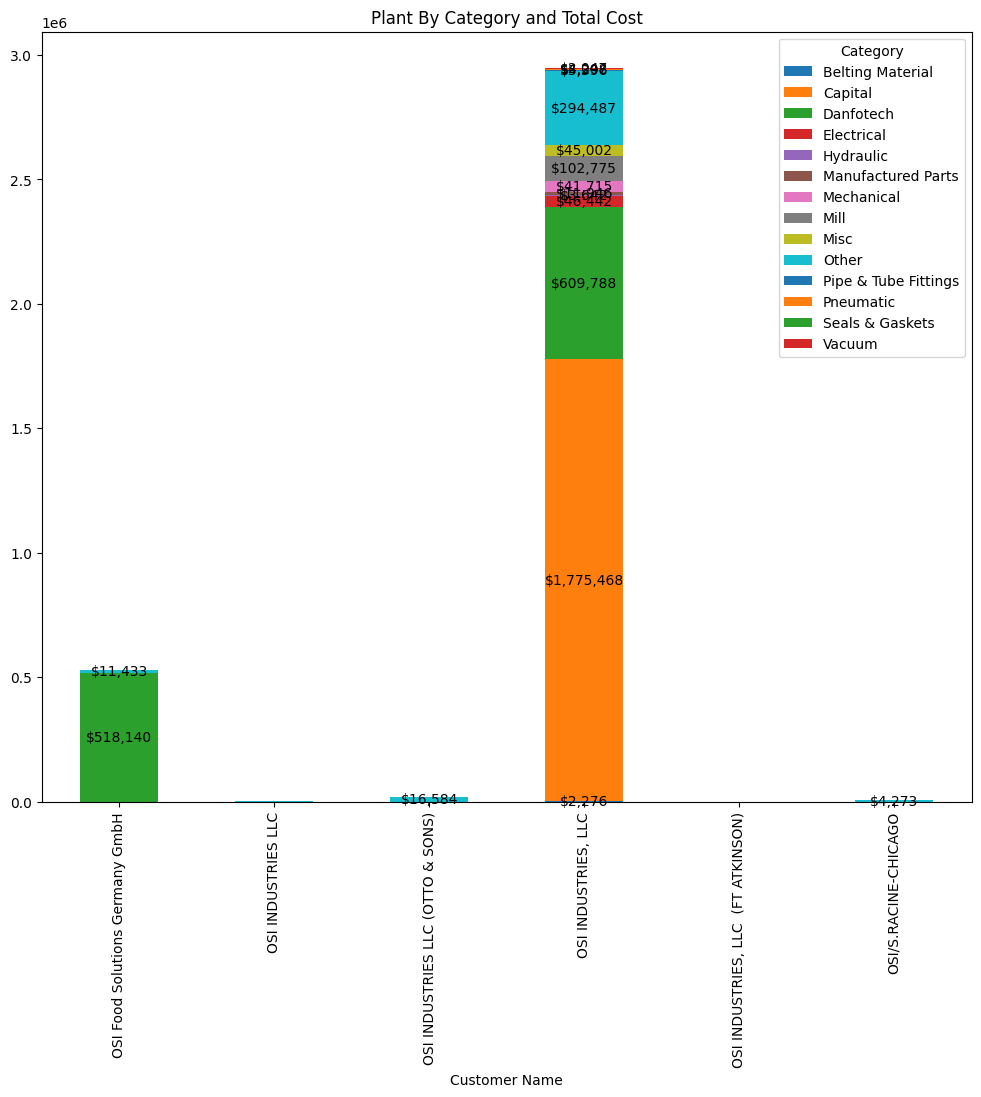

In [ ]:
###################Need to add $ amounts and category names########################################
#plot all bar-S plants by location and spending in each category
grouped_data = df.groupby(['Customer Name', 'Category'])['Total/Base'].sum().reset_index()
ax = grouped_data.pivot(index='Customer Name', columns='Category', values='Total/Base').plot(kind='bar', figsize=(12,10),stacked=True)
plt.title('Plant By Category and Total Cost')

# Add bar labels
for c in ax.containers:
    labels = [f'${v.get_height():,.0f}' if v.get_height() > 1000 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')


# Save the plot
plt.savefig(f'Plant by Categort and Total Cost.png')  # Save the figure

#Orders Info Count and lines

Text(0.5, 1.0, 'Plant By Line Items Ordered')

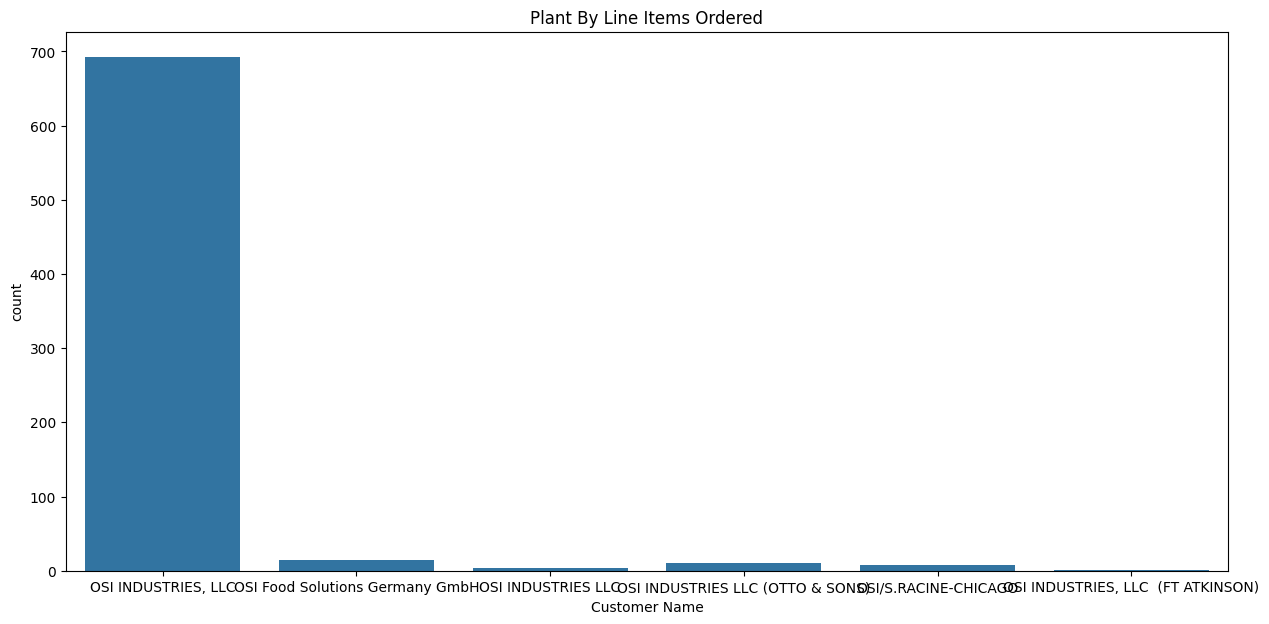

In [ ]:
# @title
#plot all Bar-S plants by the number of line items ordered

plt.figure(figsize=(15, 7))
sns.countplot(data= df, x= "Customer Name")
plt.title('Plant By Line Items Ordered')




                        Customer Name  Order No
0     OSI Food Solutions Germany GmbH        10
1                  OSI INDUSTRIES LLC         3
2    OSI INDUSTRIES LLC (OTTO & SONS)         7
3                 OSI INDUSTRIES, LLC       199
4  OSI INDUSTRIES, LLC  (FT ATKINSON)         1
5                OSI/S.RACINE-CHICAGO         5


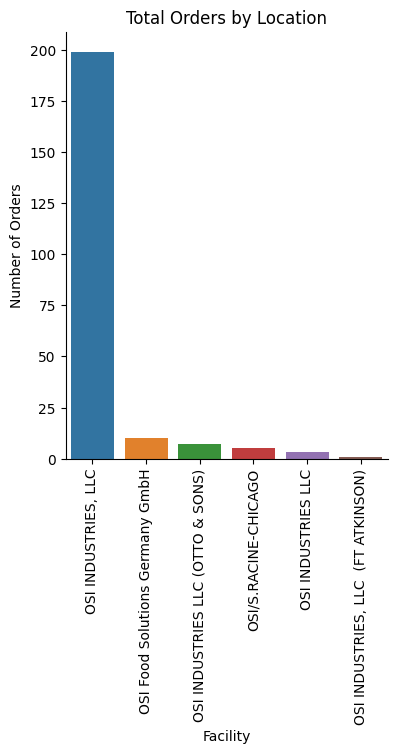

In [ ]:
# @title
#plot all Bar-S plants by the number of orders placed

grouped_data_orders = df.groupby(['Customer Name'])['Order No'].nunique().reset_index()

print(grouped_data_orders)
#plt.figure(figsize=(15, 7))
#sns.barplot(data= grouped_data_orders, y= 'Customer Name', hue = 'Order No')

sns.catplot(x='Customer Name', y='Order No', data=grouped_data_orders.sort_values('Order No', ascending=False), kind="bar", hue='Customer Name')
plt.title('Total Orders by Location')
plt.xlabel('Facility')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.show()

#need to add numbers to the graph

                                          Total Cost
Customer Name                   Order No            
OSI Food Solutions Germany GmbH E6421           0.00
                                E6422       10000.00
                                E6483       10000.00
                                E6539       10000.00
                                E6541       19578.08


<Axes: xlabel='Customer Name', ylabel='Total Cost'>

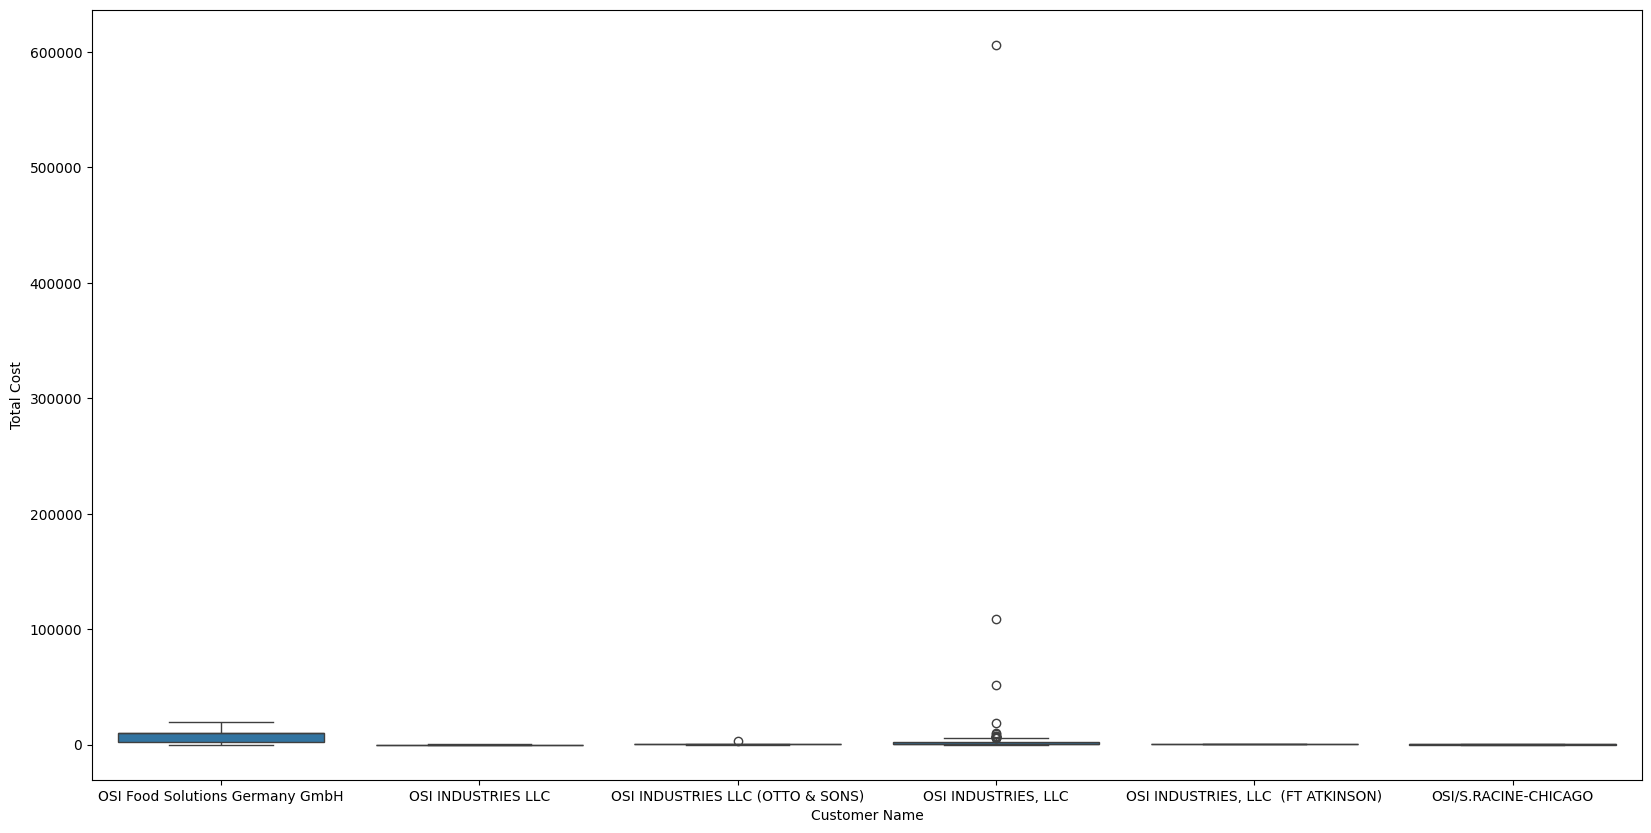

In [ ]:
# @title
#whisker chart of order value by facility

PO_Costdf = pd.DataFrame(df.groupby(['Customer Name', 'Order No'])['Total Cost'].sum())
print(PO_Costdf.head())

plt.figure(figsize=(20, 10))
sns.boxplot(data=PO_Costdf, x='Customer Name', y = 'Total Cost')

#change scale and add numbers

#Skipped Items

In [ ]:
%%script echo skipping
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

skipping


#Category spend throughout plants

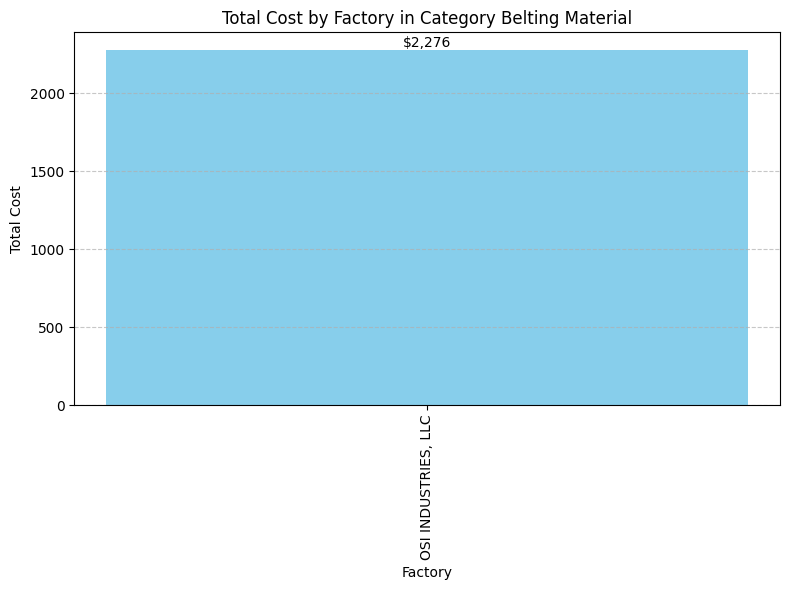

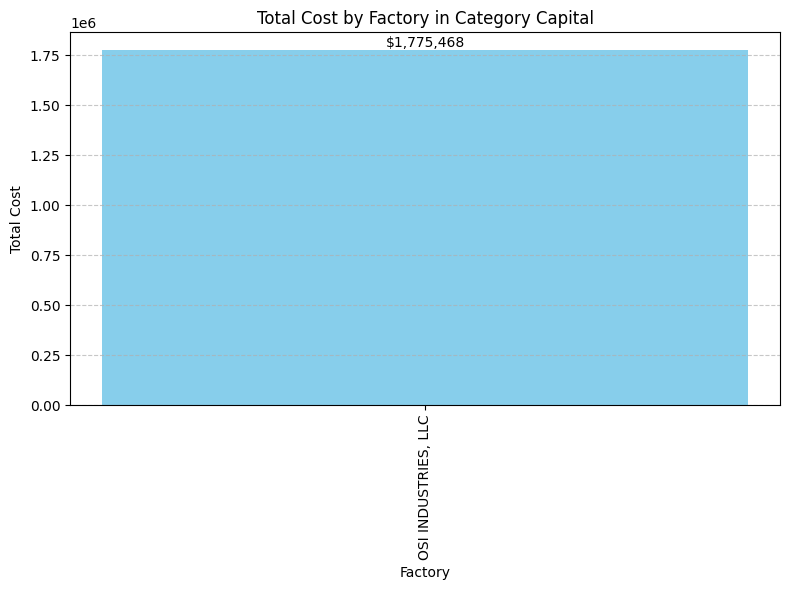

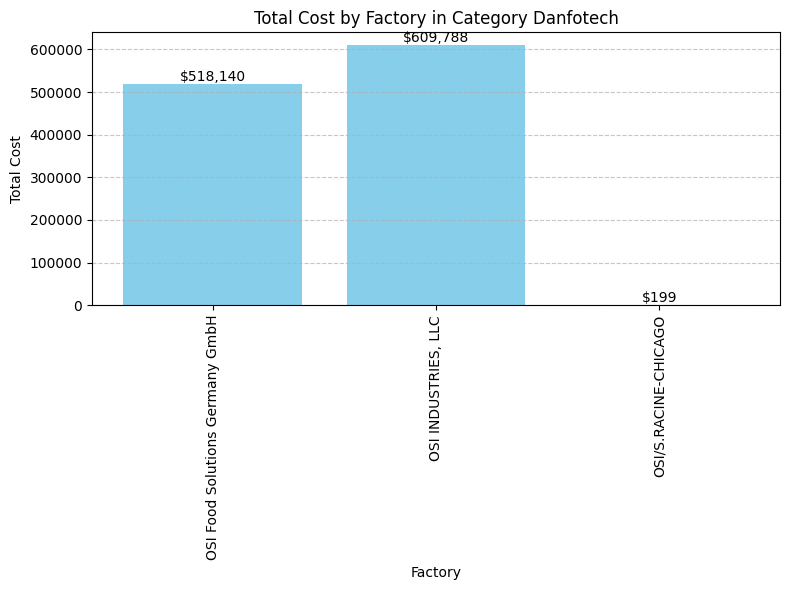

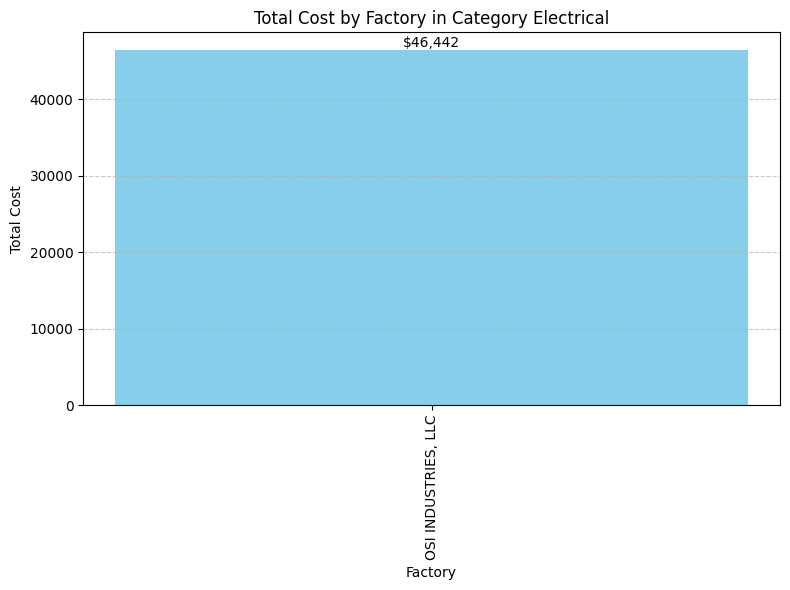

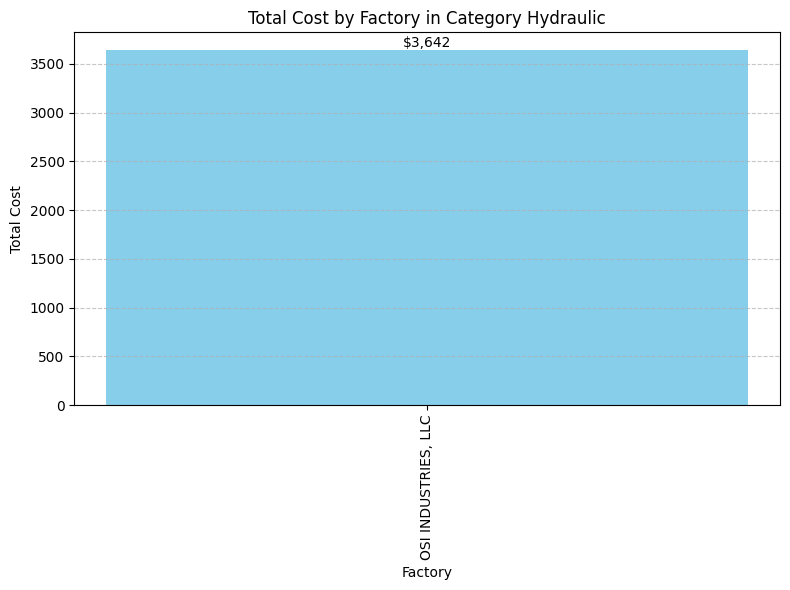

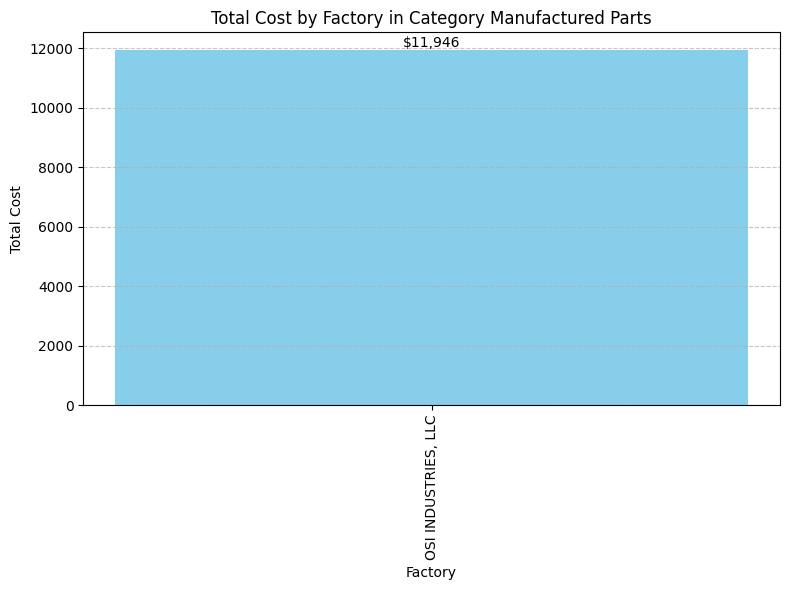

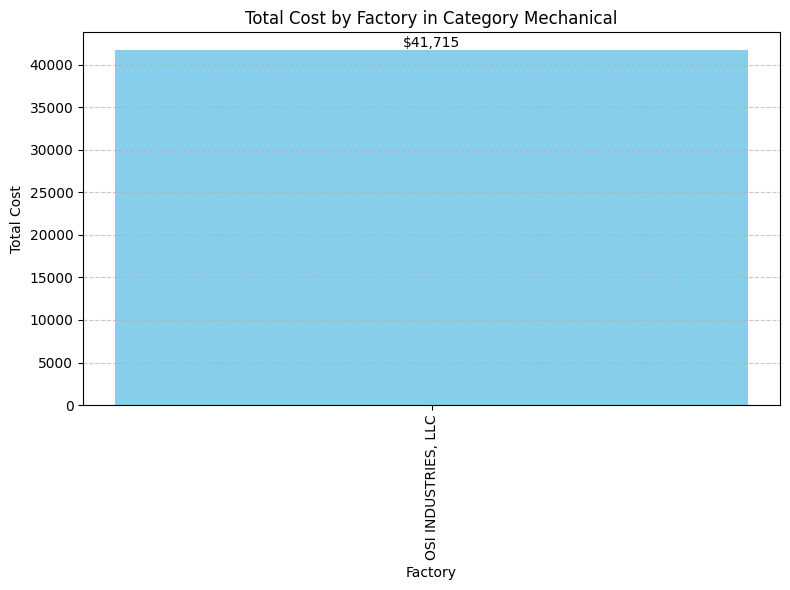

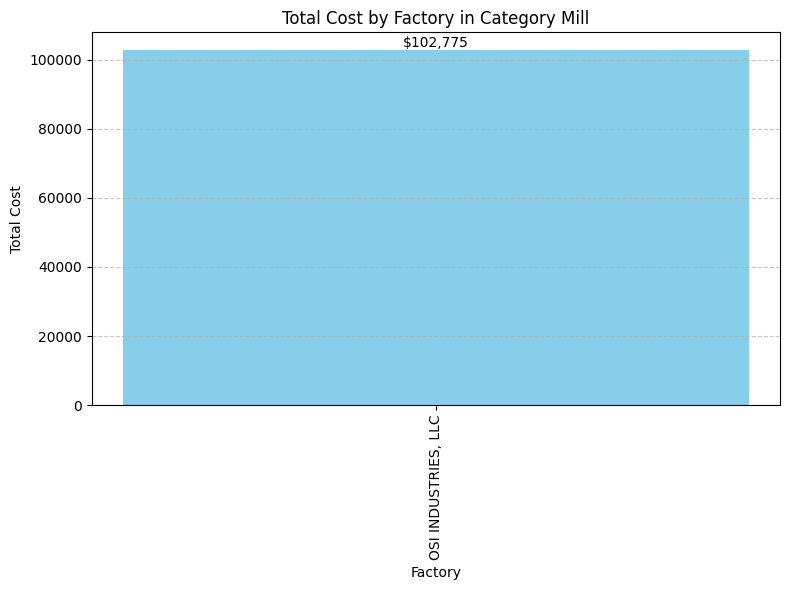

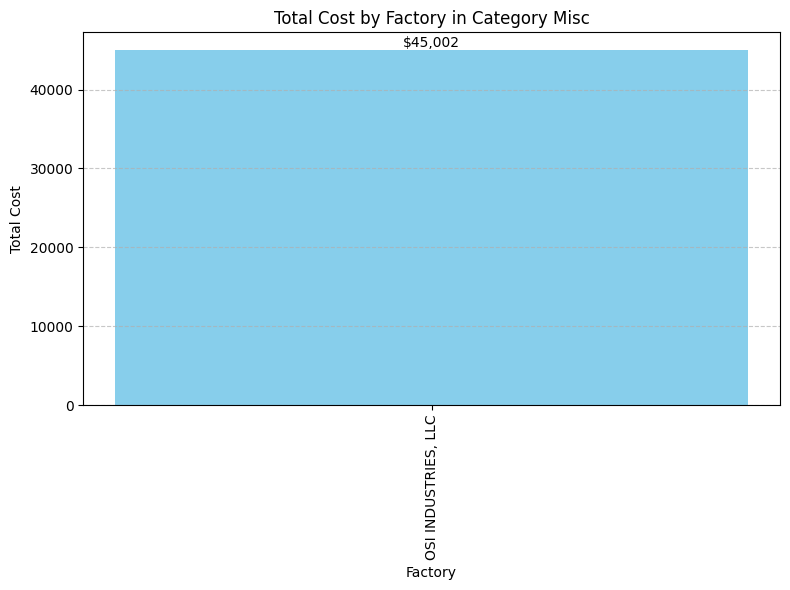

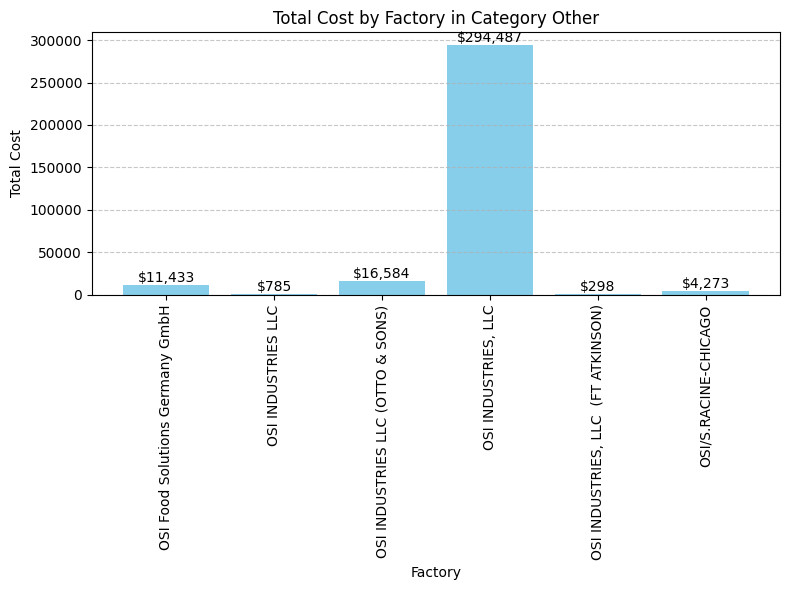

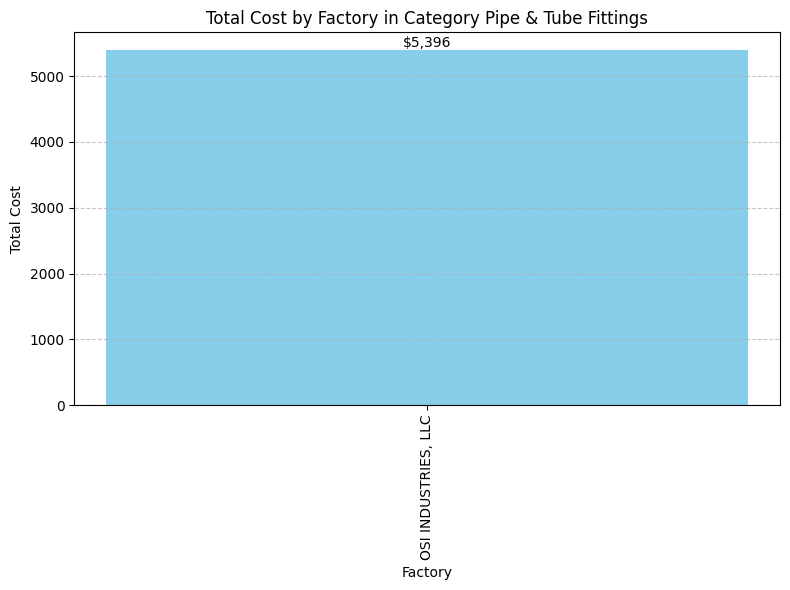

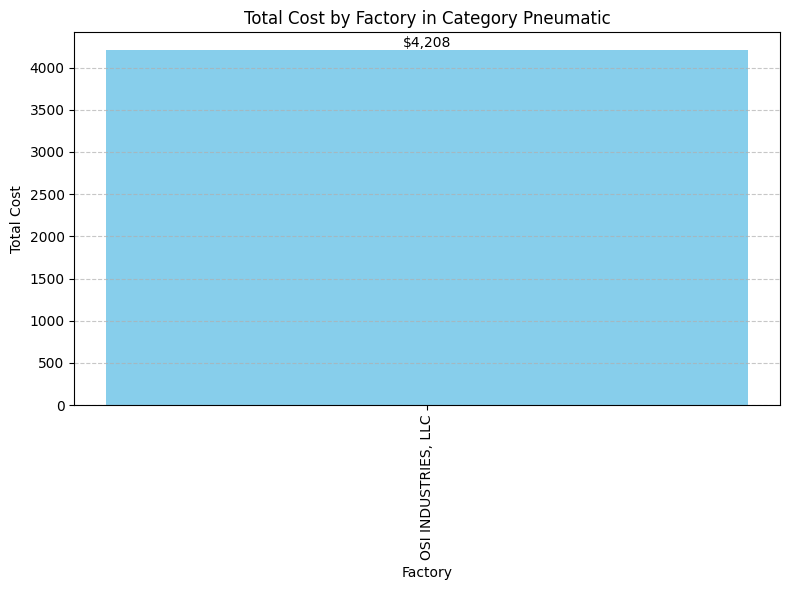

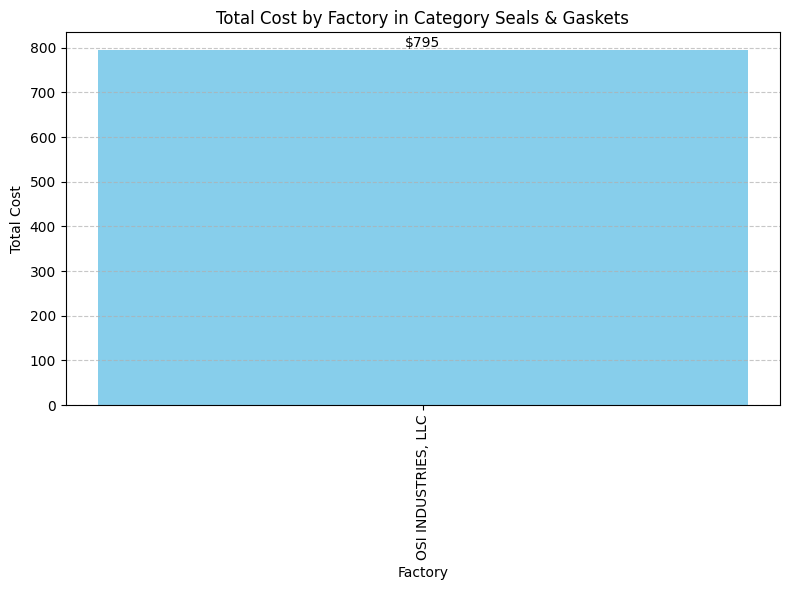

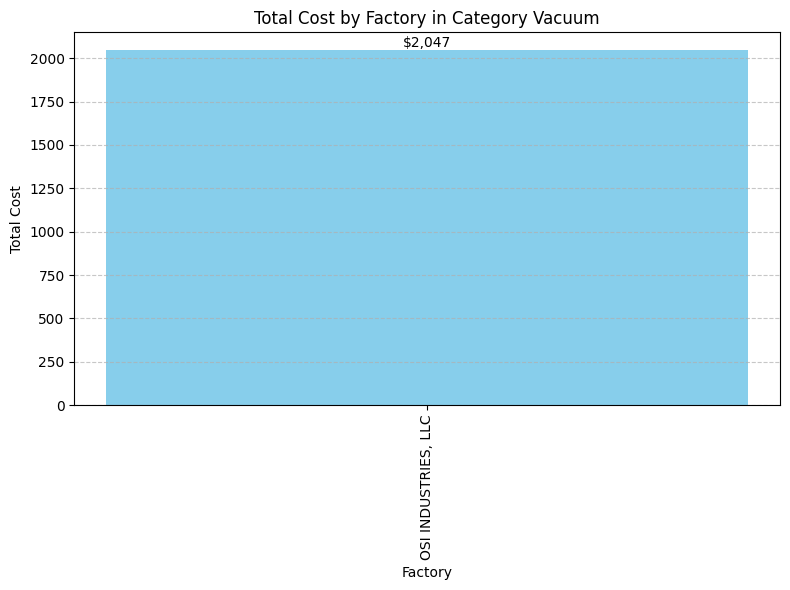

In [ ]:
# @title
# Group data by Category and Factory, then sum the costs
grouped1 = df.groupby(['Category', 'Customer Name'])['Total/Base'].sum().reset_index()

# Get unique categories
categories = grouped1['Category'].unique()

# Plot each category
for category in categories:
    category_data = grouped1[grouped1['Category'] == category]

    # Create a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(category_data['Customer Name'], category_data['Total/Base'], color='skyblue')
    plt.title(f'Total Cost by Factory in Category {category}')
    plt.xlabel('Factory')
    plt.xticks(rotation=90)  # Rotate x-axis labels
    plt.ylabel('Total Cost')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Add labels on top of the bars
    for index, value in enumerate(category_data['Total/Base']):
        plt.text(index, value, f'${value:,.0f}', ha='center', va='bottom')

    # Save the plot or show it
    plt.savefig(f'Category_{category}_Cost.png')  # Save the figure
    plt.show()  # Display the figure


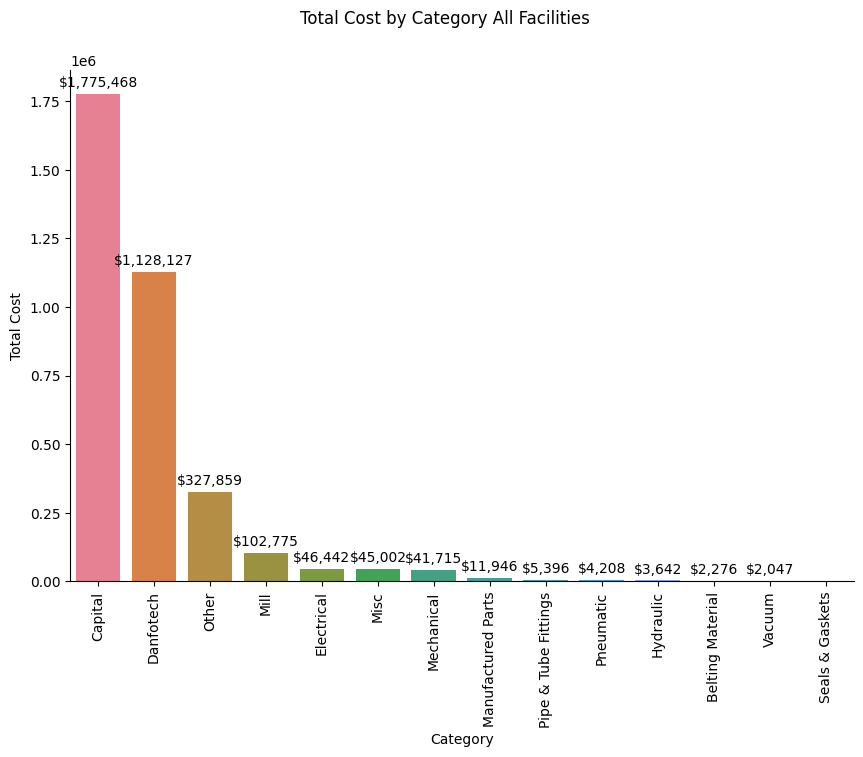

In [ ]:
#test from improved chat gpt code
# Create the catplot and store the returned FacetGrid object
g = sns.catplot(
    x='Category',
    y='Total/Base',
    data=grouped_Category.sort_values('Total/Base', ascending=False),
    kind="bar",
    hue='Category',
    height=6,
    aspect=1.5
)

# Set title and labels using the FacetGrid
g.fig.suptitle('Total Cost by Category All Facilities', y=1.05)  # y > 1.0 to avoid title being cut off
g.set_axis_labels('Category', 'Total Cost')
g.set_xticklabels(rotation=90)

#############################New Addition############################################
# Add bar labels
for ax in g.axes.flat:
  for container in ax.containers:
    labels = [f'${v.get_height():,.0f}' if v.get_height() > 1000 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding = 3)
####################################################################################

# Save using the FacetGrid's figure
g.savefig("Top Cost by Category.png")

# Show the plot
plt.show()

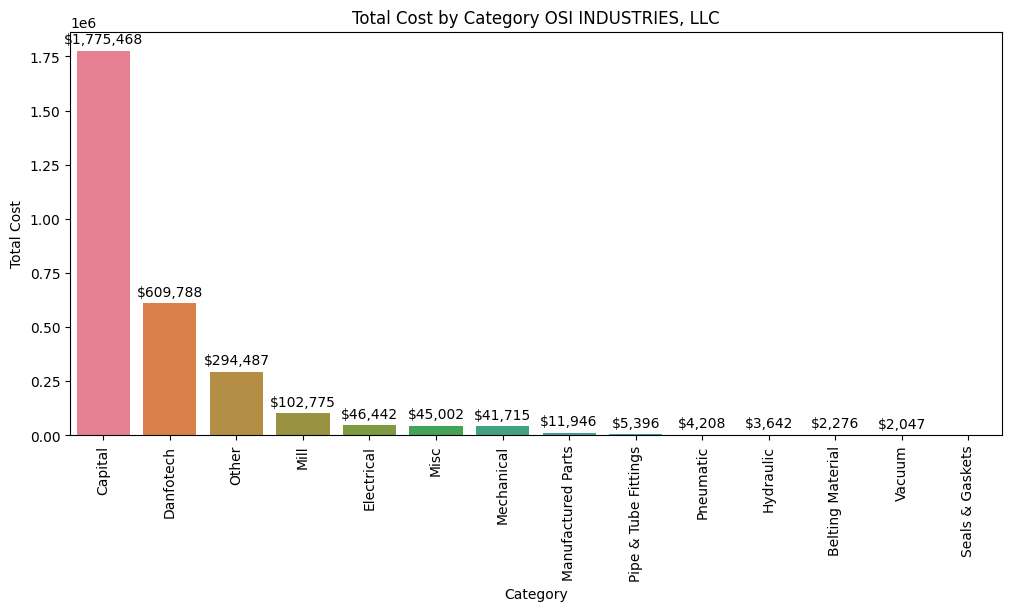

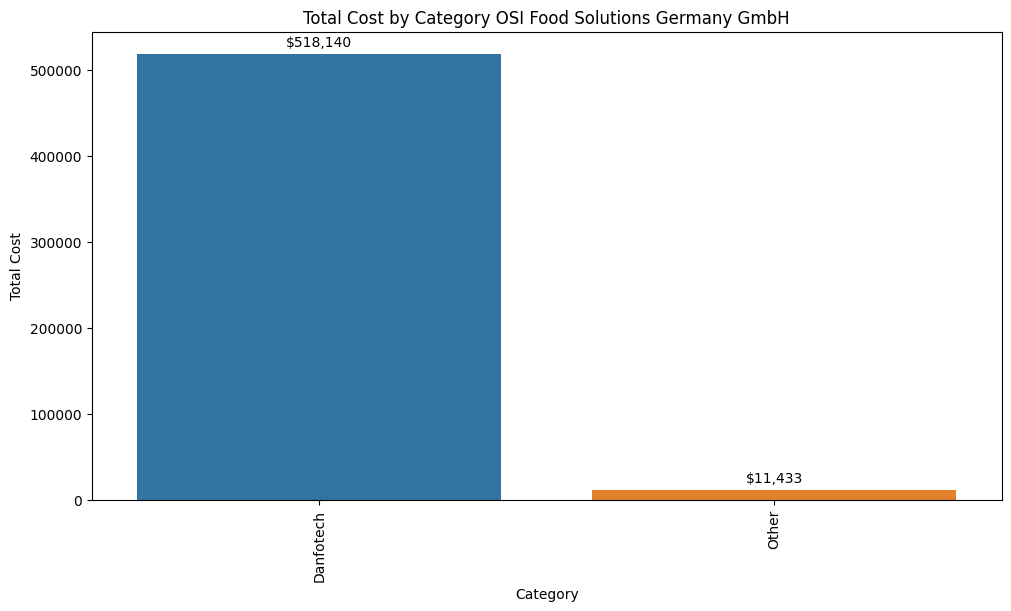

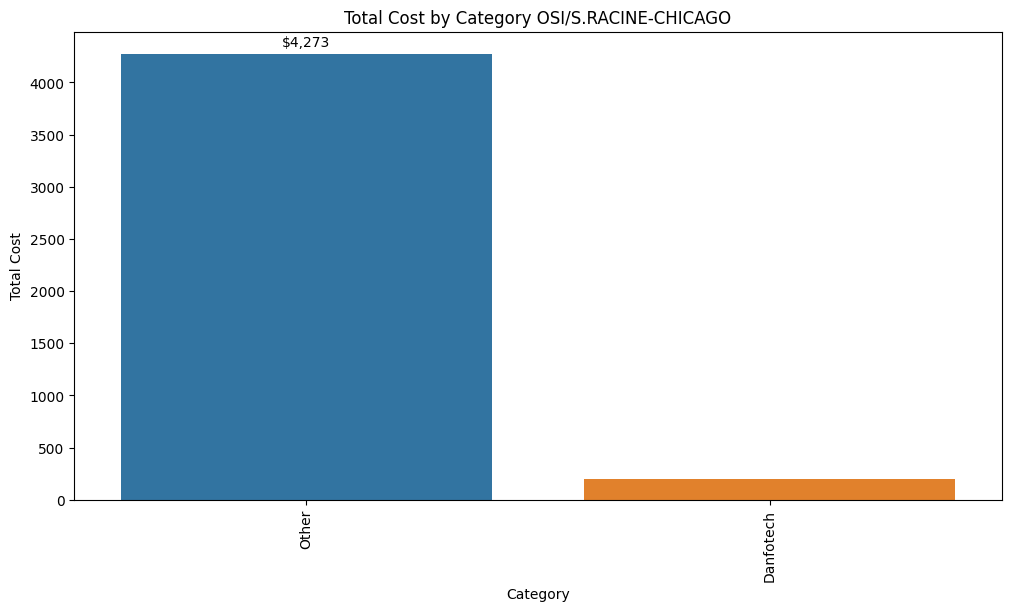

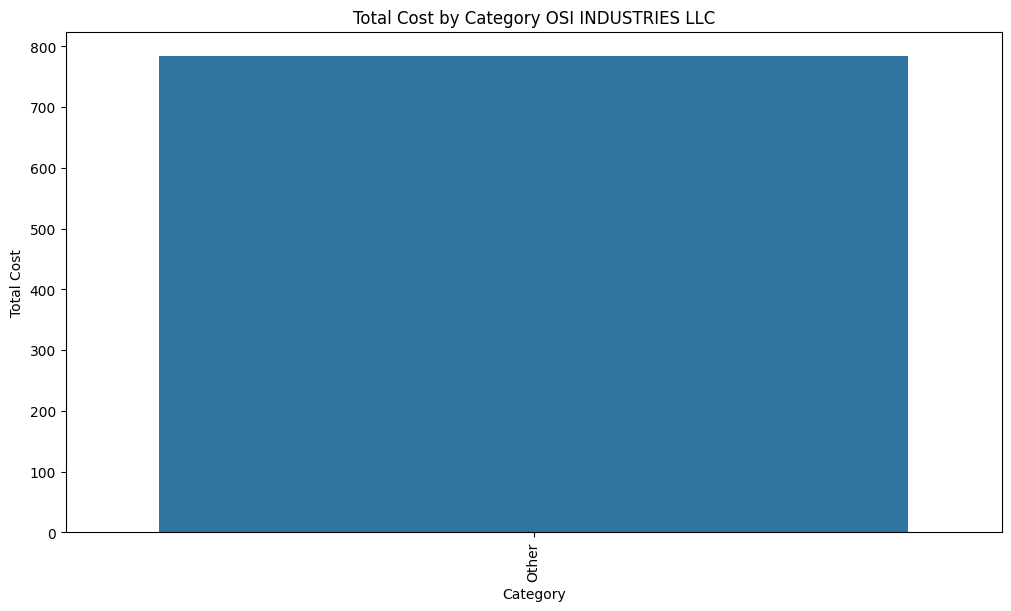

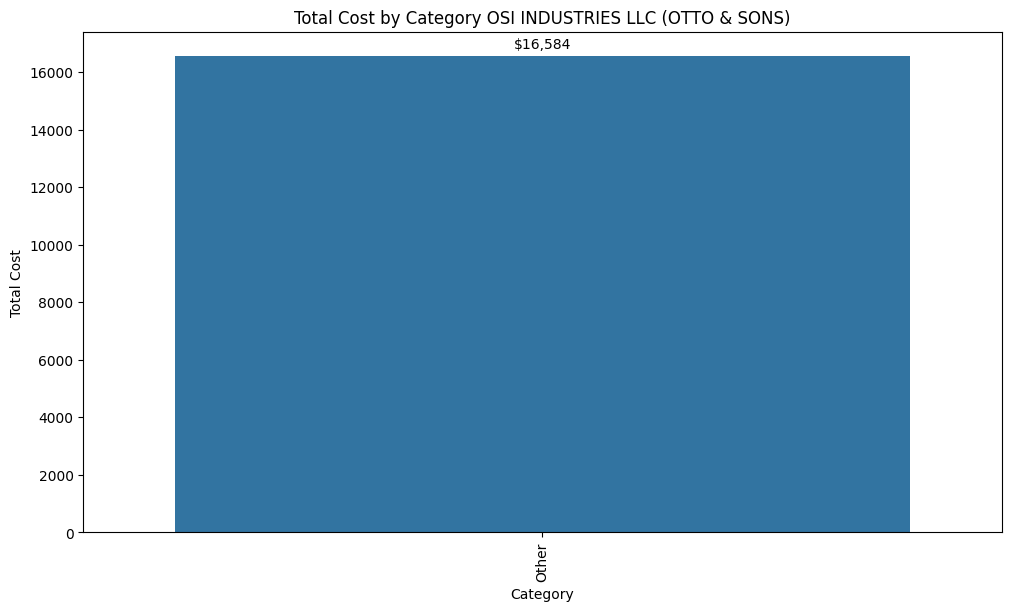

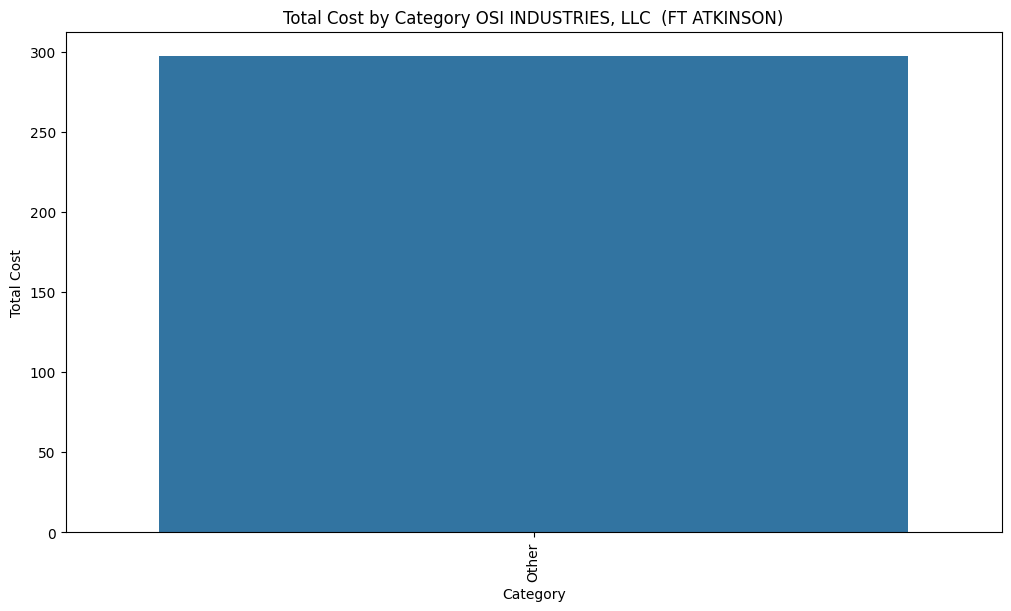

In [ ]:
# @title
#Need total cost by factory
#Group data by Category and Factory, then sum the costs for each factory

#grouped1 = df.groupby(['Category', 'Customer Name'])['Total/Base'].sum().reset_index()

# Get unique factories
Factories = grouped1['Customer Name'].unique()

# Plot each category
for factory in Factories:
    category_data = grouped1[grouped1['Customer Name'] == factory]

# Create a new figure for each factory
    plt.figure(figsize=(10, 6), constrained_layout=True)  # Adjust size as needed

    g = sns.barplot(
        x='Category',
        y='Total/Base',
        data=category_data.sort_values('Total/Base', ascending=False),
        hue='Category',
        dodge=False  # prevent duplicated bars
    )
    plt.title(f'Total Cost by Category {factory}')
    #plt.title(f'Total Cost by Factory in Category {category}')
    plt.xlabel('Category')
    plt.ylabel('Total Cost')
    plt.xticks(rotation=90)

    # Add labels on top of the bars
    for container in g.containers:
        labels = [f'${v.get_height():,.0f}' if v.get_height() > 1000 else '' for v in container]
        g.bar_label(container, labels=labels, label_type='edge', padding=3)

    # Save the plot
    safe_factory_name = factory.replace('/', '_').replace('\\', '_')  # clean filename
    plt.savefig(f'Total_Cost_by_Category_{safe_factory_name}.png')
    plt.show()




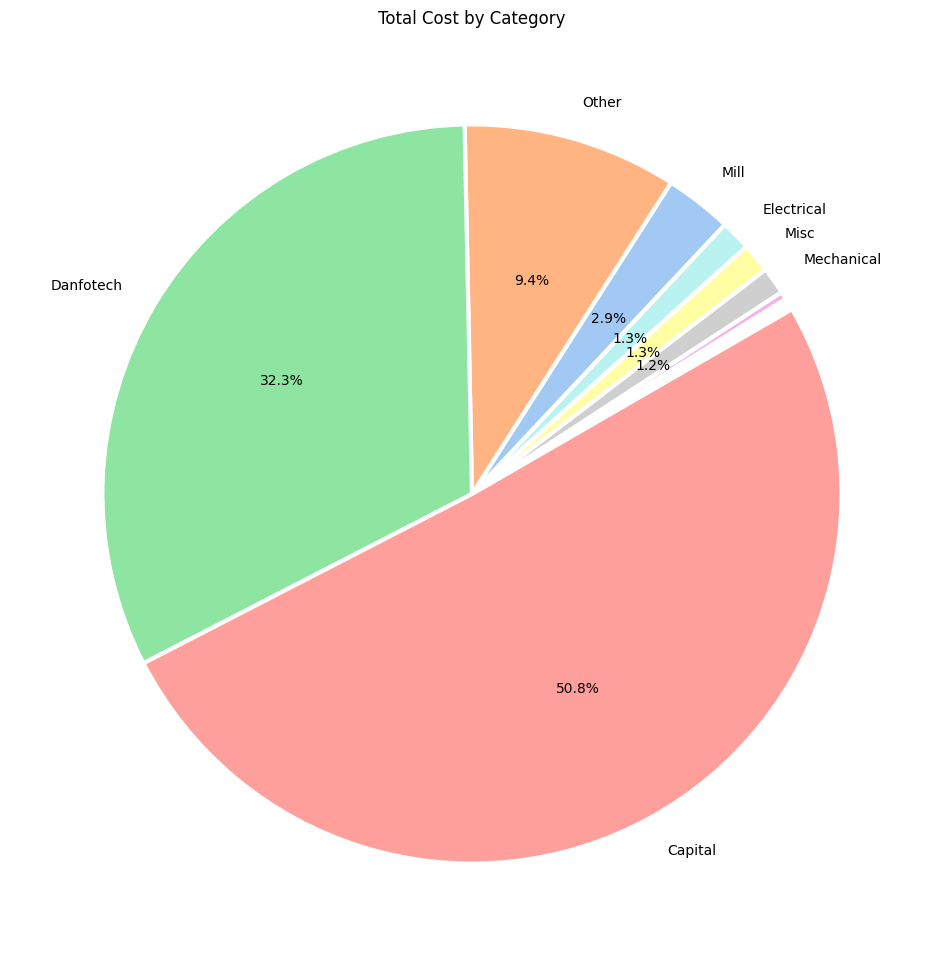

In [ ]:
# @title
#Pie Chart for the above

# Assuming `grouped_Category` is your DataFrame
# Ensure the data is sorted as needed
#grouped_CategoryPie = grouped_Category.sort_values('Total Cost', ascending=False)
grouped_CategoryPie = grouped_Category.sort_values('Total/Base')


# Prepare data for the pie chart
labels = grouped_CategoryPie['Category']
sizes = grouped_CategoryPie['Total/Base']

#explode = [0.01] + [0] * (len(sizes)-1)  # Explode the first slice by 0.1

# Function to hide labels below a certain value
def hide_small_labels(pct, threshold):
    return '' if pct < threshold else f'{pct:.1f}%'


# Plotting the pie chart
plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: hide_small_labels(pct, 0),#'%1.1f%%',
    colors=sns.color_palette("pastel"),
    startangle=30,
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    #labeldistance=1.2
    #explode = explode
)
plt.title('Total Cost by Category')
#plt.tight_layout()

#set threshold to ommit label and % number from pie chart
threshold = 1
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')

plt.show()

#need better formatting

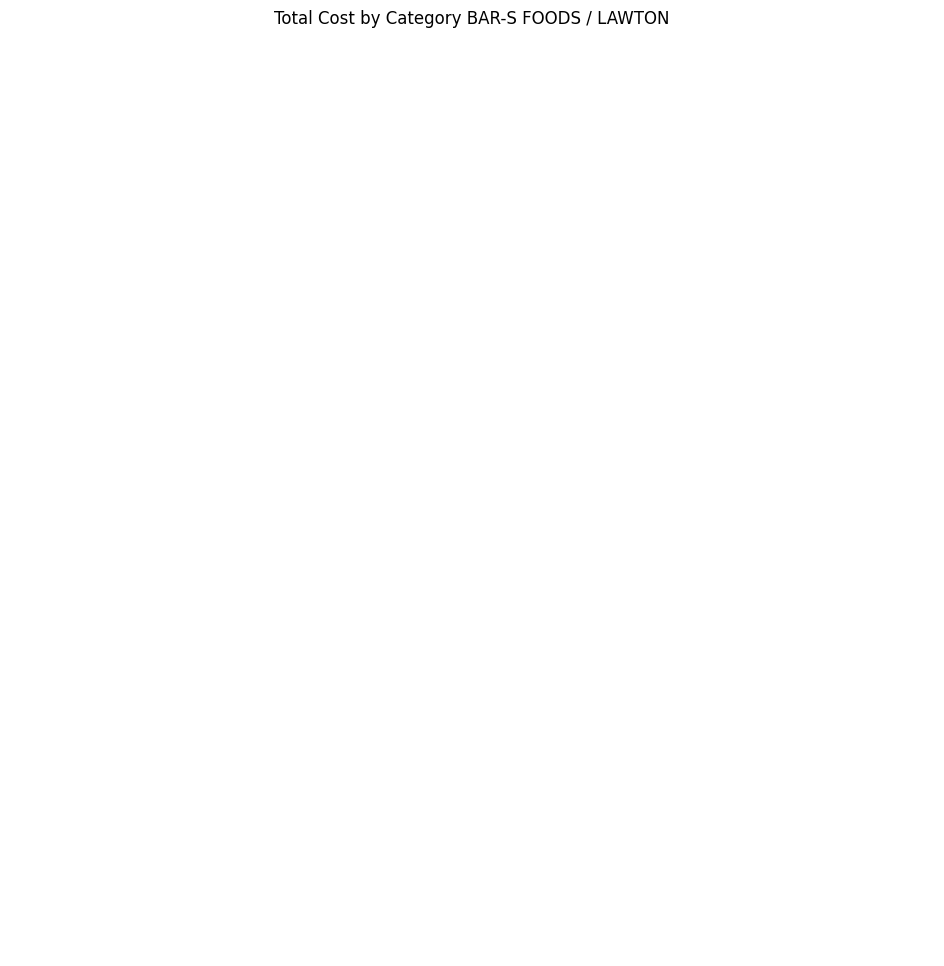

In [ ]:
# @title
#Pie Chart for each factory

###Works for Lawton, Need to do for other facories and display, good to add a loop.

#Filter for Lawton
#BAR-S FOODS/LAWTON
##############################################################
# Function to filter DataFrame by customer name
def filter_by_customer(df, customer_name):
    return df.loc[df['Customer Name'] == customer_name]

###Add loop here for each facotry####################################################

# Example usage
customer_name = 'BAR-S FOODS / LAWTON'
filtered_dfPie = filter_by_customer(df, customer_name)

filtered_dfPie.groupby('Category')['Total/Base'].sum().reset_index()
Pie = filtered_dfPie.groupby('Category')['Total/Base'].sum().reset_index()
#####################################################

# Assuming `grouped_Category` is your DataFrame
#Pie = filtered_dfPie.sort_values('Total/Base')

# Prepare data for the pie chart
labels = Pie['Category']
sizes = Pie['Total/Base']

#explode = [0.01] + [0] * (len(sizes)-1)  # Explode the first slice by 0.1

# Function to hide labels below a certain value
def hide_small_labels(pct, threshold):
    return '' if pct < threshold else f'{pct:.1f}%'


# Plotting the pie chart
plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: hide_small_labels(pct, 0),#'%1.1f%%',
    colors=sns.color_palette("pastel"),
    startangle=30,
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    #labeldistance=1.2
    #explode = explode
)
plt.title(f'Total Cost by Category {customer_name}')
#plt.tight_layout()

#set threshold to ommit label and % number from pie chart
threshold = 1
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')

plt.show()

#need better formatting

#Hidden for now

In [ ]:
#%%script echo skipping
#take a look at all the other parts to break down better
dfOtherParts = df[df['Category']=='Other']
dfOtherParts.head()

#how many unique sales part no?

dfOtherParts['Sales Part No'].nunique()

dfUniqueOtherParts = dfOtherParts['Sales Part No'].unique()
print(dfUniqueOtherParts)

#dfUniqueOtherParts.head(100).sample(n=10)

dfOtherParts['Category Code Other'] = dfOtherParts['Sales Part No'].str[:5]

dfOtherParts.head(100).sample(n=10)

['CVP3X037' 'CVP3X016' 10036 'AN1980135' 'AN80300672' 'CVP3X034' 70350
 70360 80270 6040 'AN1981275' 'AN80300596' 'AN1980550' 'AN80300572'
 'AN1981568' 'AN00402668' 'AN01902219' 'AN80300720' 'SS308V13B'
 'AN1980232' 'AN01200922' 'AN1981662' 'AN80200004' 'FED_BILLSERVICE_20'
 'EXPENSE' 'TNA_BILLSERVICE_80' 'TNA_NI_PART_80' 'AN1985320' 'AN81900034'
 'VEXXX401' 80269 80306 10022 'AN80300568' 'AN80300571' 'SS204W01B'
 'AN80301690' 'AN1985322' 'SPXXX418A' 70025 80271 'AN1985316' 6999 10028
 10032 'ANZ05614' 'FREIGHT' 'AN84400006' 'VEFCP312B' 'FED_NI_PART_20'
 'SPX9P111B' 'CVP3X012' 'SPX9P311B' 70390 80260 'AN1984951' 'DWG A-0548'
 'AN80301617' 'AN00509102' 'AN81300070' 'AN81300049' 'SLXXX350B-45916'
 'DWG A-1035-1-SR' 'DWG A-1035-2-SR' 'AN80400151' 70340 'AN2751505']


/tmp/ipython-input-269-756171100.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfOtherParts['Category Code Other'] = dfOtherParts['Sales Part No'].str[:5]


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Category Code Other
151,A259896,8,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,VEXXX401,PIVOT ADJUSTMENT,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,VE,Other,VEXXX
438,I39735,1,1,Invoiced/Closed,NOR,91599,OSI INDUSTRIES LLC (OTTO & SONS),IOWA,70390,REV UNIT IDLE,...,0,Other,UT,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN
364,A261509,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FREIGHT,SHIPPING COSTS,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FR,Other,FREIG
267,A260998,1,1,Invoiced/Closed,SVO,95160,"OSI INDUSTRIES, LLC",CHI,FED_BILLSERVICE_20,SERVICE CHARGE,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other,FED_B
198,T27649,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN1985322,CONVEYOR BELT - LONG (WHITE),...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN198
367,A261523,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,SPX9P111B,"PUMP DRIVE SHAFT 3""",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,SP,Other,SPX9P
109,A260042,11,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X037,"ROTOR 3"" PUMP W/THRUST WSHR",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X
83,T27115,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN1981275,4600 BLADE DRIVE GEARBOX,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN198
103,A260005,1,1,Invoiced/Closed,SVO,95160,"OSI INDUSTRIES, LLC",CHI,FED_BILLSERVICE_20,SERVICE CHARGE,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other,FED_B
339,T27969,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN81900034,TIMING BELT BRECOFLEX,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN819


In [ ]:
print(dfOtherParts['Total/Base'].sum())
dfOtherParts

327859.22


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Category Code Other
20,A259593,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X037,"ROTOR 3"" PUMP W/THRUST WSHR",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X
27,A259795,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X016,WEAR LINER,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X
32,A259824,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X037,"ROTOR 3"" PUMP W/THRUST WSHR",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X
51,I38869,1,1,Invoiced/Closed,NOR,96820,OSI INDUSTRIES LLC,IOWA,10036,24VDC COIL KIT 1860156,...,0,Other,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN
52,T26883,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN1980135,SHEAR EDGE REV 4-PLASTIC,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,A262585,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,10028,"VALVE,OPEN, 24VDC",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN
712,I39975,1,1,Reserved,NOR,91599,OSI INDUSTRIES LLC (OTTO & SONS),IOWA,70350,TIMING BELT **BY THE INCH**,...,0,Other,UT,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN
720,A262734,1,1,Released,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X034,VANE SET (REV E),...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X
721,A262734,2,1,Released,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X037,"ROTOR 3"" PUMP W/THRUST WSHR",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X


In [ ]:
#test to get top ten other parts by cost

# Group by Sales Part No and sum Sales Qty and Total/Base
summary = dfOtherParts.groupby("Sales Part No", as_index=False).agg({
    "Sales Qty": "sum",
    "Total/Base": "sum"
})

# Merge with unique descriptions
descriptions = dfOtherParts[["Sales Part No", "Description"]].drop_duplicates("Sales Part No")
summary = summary.merge(descriptions, on="Sales Part No", how="left")

# Get top 10 parts by Total/Base
top_other_parts = summary.sort_values(by=["Total/Base", "Sales Qty"], ascending=False).head(10).reset_index(drop=True)

# Display results
print(top_other_parts)
print("Total cost of top 10 parts in other category: $", top_other_parts["Total/Base"].sum())


        Sales Part No  Sales Qty  Total/Base                       Description
0  FED_BILLSERVICE_20          7   115838.26                    SERVICE CHARGE
1            CVP3X037         16    24832.51       ROTOR 3" PUMP W/THRUST WSHR
2             EXPENSE          7    20721.82                    TRAVEL EXPENSE
3      FED_NI_PART_20          4    19262.90            24/7 AFTER HOUR CHARGE
4  TNA_BILLSERVICE_80          1    14215.50                    SERVICE CHARGE
5             FREIGHT          2    13559.92                    FREIGHT CHARGE
6           AN1980135         12    12959.28          SHEAR EDGE REV 4-PLASTIC
7           AN1985316          4     9912.64  CONVEYOR BELT LANES 2 & 4 (WHITE
8            CVP3X016         10     8007.00                        WEAR LINER
9            CVP3X034         15     6514.10                  VANE SET (REV E)
Total cost of top 10 parts in other category: $ 245823.93000000002


In [ ]:
save_df_as_excel_table_auto(top_other_parts, 'top_other_parts_all_Bar-S')

✅ Excel file saved to: /content/top_other_parts_all_Bar-S.xlsx


#Misc. parts top 10.

In [ ]:
#take a look at all the other parts to break down better
dfMiscParts = df[df['Category']=='Misc']
dfMiscParts.head()

#how many unique sales part no?

dfMiscParts['Sales Part No'].nunique()

dfUniqueMiscParts = dfMiscParts['Sales Part No'].unique()
print(dfUniqueMiscParts)

#dfUniqueOtherParts.head(100).sample(n=10)

dfMiscParts['Category Code Other'] = dfMiscParts['Sales Part No'].str[:5]

dfMiscParts.head(100).sample(n=10)

['07-FLO-50081' '07-FLO-50080' '07-FLO-50040' '07-FLO-50015'
 '07-FLO-50023' '07-FLO-50012' '07-FLO-50003' '07-FLO-50009'
 '07-FLO-50004' '07-FLO-50005' '07-001-0011' '07-FLO-50057'
 '07-FLO-65003B' '07-FLO-50041' '07-001-0010' '07-001-0004']


/tmp/ipython-input-273-243596409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMiscParts['Category Code Other'] = dfMiscParts['Sales Part No'].str[:5]


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Category Code Other
672,A262565,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50057,"SEAL HSG, O-RING, UNIBLOC",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
434,A261370,8,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-001-0010,"STEEL BUSHING SET 3"" PUMP",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-00
417,A261507,10,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-001-0004,CAM HEART SHAPE,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-00
139,A260131,5,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50004,"DRIVE SHAFT, CHAR-LYNN",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
630,A262350,6,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-001-0004,CAM HEART SHAPE,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-00
107,A260042,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50040,"O-RING,SHAFT SEAL, UNIBLOC 500",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
274,A260803,6,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50005,LAY SHAFT - PLASTIC ROTOR,...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
136,A260131,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50012,"TAB WASHER, UNIBLOC 500",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
380,A261560,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50009,"BEARINGS, FRONT/REAR UNIBLOCK",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL
355,A261447,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,07-FLO-50040,"O-RING,SHAFT SEAL, UNIBLOC 500",...,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,07,Misc,07-FL


In [ ]:
#test to get top ten other parts by cost

# Group by Sales Part No and sum Sales Qty and Total/Base
summary = dfMiscParts.groupby("Sales Part No", as_index=False).agg({
    "Sales Qty": "sum",
    "Total/Base": "sum"
})

# Merge with unique descriptions
descriptions = dfMiscParts[["Sales Part No", "Description"]].drop_duplicates("Sales Part No")
summary = summary.merge(descriptions, on="Sales Part No", how="left")

# Get top 10 parts by Total/Base
top_misc_parts = summary.sort_values(by=["Total/Base", "Sales Qty"], ascending=False).head(10).reset_index(drop=True)

# Display results
print(top_misc_parts)
print("Total cost of top 10 parts in other category: $", top_misc_parts["Total/Base"].sum())

   Sales Part No  Sales Qty  Total/Base                    Description
0   07-FLO-50003         13    10360.78                 ROTOR 500 PUMP
1  07-FLO-65003B          4     9736.66           ROTOR FOR PD650 PUMP
2   07-FLO-50005          3     5870.13      LAY SHAFT - PLASTIC ROTOR
3   07-FLO-50004          3     5722.05         DRIVE SHAFT, CHAR-LYNN
4   07-FLO-50009         16     3233.80  BEARINGS, FRONT/REAR UNIBLOCK
5   07-FLO-50015         18     2252.07      HOUSING STUD, UNIBLOC 500
6   07-FLO-50080         10     2053.13                   SHAFT SLEEVE
7    07-001-0010          8     1592.20      STEEL BUSHING SET 3" PUMP
8   07-FLO-50041          2     1288.02   DOUBLE O-RING SEAL FLUSH HSG
9    07-001-0011         12     1092.57             SWING BOLT 3" PUMP
Total cost of top 10 parts in other category: $ 43201.409999999996


In [ ]:
save_df_as_excel_table_auto(top_misc_parts, f'top_misc_parts_all_{most_common_customer}')

✅ Excel file saved to: /content/top_misc_parts_all_Bar-S.xlsx


In [ ]:
print(top_misc_parts['Total/Base'].sum())

43201.409999999996


In [ ]:
#%%script echo skipping
#look at new categories
print(dfOtherParts['Category Code Other'].value_counts())

#display all CVP3X items
dfOtherParts[dfOtherParts['Category Code Other'] == 'CVP3X']

#display all pump drive shafts SPX9P111B
print(df[df['Sales Part No'] == 'SPX9P111B'].value_counts())
df.head()

Category Code Other
CVP3X    25
AN198    17
AN803    11
EXPEN     7
FED_B     7
FED_N     4
SPX9P     3
AN019     3
DWG A     3
AN819     2
SS204     2
FREIG     2
AN813     2
ANZ05     2
SPXXX     2
TNA_B     1
SS308     1
AN004     1
AN012     1
AN802     1
TNA_N     1
VEFCP     1
VEXXX     1
AN844     1
AN005     1
SLXXX     1
AN804     1
AN275     1
Name: count, dtype: int64
Order No  Line No  Del No  Status           Order Type  Customer No  Customer Name        Site  Sales Part No  Description          Configurable    Configuration ID  Condition Code  Condition Code Description  Interim Order  Sales Part Type  Part No    Purchase Part No  Supply Code   Supplier  Supply Site  Supply Site Qty Reserved  Supply Site Reservation Type  Sales Qty  Desired Qty  Conv Factor  Revised Qty  Price List No  Price List Description  Price Source  Price Source ID  Consignment Stock     Ownership      Owner  Owning Customer Name  Charged Item  Qty Reserved  Qty Picked  Qty Short  Qty Pegged  Qty N

,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category
0,P24108,5,2,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,SKID AND CRATE,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Capital
1,P24108,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-1,PALLET RETRACT VAT DUMPER,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,P2,Capital
2,P24108,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-2,PALLET RETRACT VAT DUMPER,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,P2,Capital
3,P24108,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,P24108-CVD626-3,PALLET RETRACT VAT DUMPER,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,P2,Capital
4,P24108,5,1,Cancelled,NOR,95160,"OSI INDUSTRIES, LLC",CHI,FED_NI_PART_20,SKID AND CRATE,...,FOB ORIGIN FRT PREPAID & ADD,0,Other,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Capital


In [ ]:
# Count the number of times a specific part number appears
part_number = 'SPX9P327'
count = df['Sales Part No'].value_counts().get(part_number, 0)

print(f"Count of part number {part_number}: {count}")
df.info()

Count of part number SPX9P327: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Columns: 131 entries, Order No to Category
dtypes: bool(3), datetime64[ns](6), float64(12), int64(26), object(84)
memory usage: 730.3+ KB


In [ ]:
#%%script echo skipping
dfOtherParts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 20 to 726
Columns: 132 entries, Order No to Category Code Other
dtypes: bool(3), datetime64[ns](6), float64(12), int64(26), object(85)
memory usage: 133.4+ KB


In [ ]:
#take a look at all the other parts to break down better
dfOtherParts

#how many unique sales part no?

#print(dfOtherParts['Sales Part No'].nunique())

dfUniqueOtherParts = dfOtherParts['Sales Part No']
#print(dfUniqueOtherParts)


def categorize_other_part(description):
    if 'CVP3X' in str(description):
        return 'Vane Pump'
    elif 'SPX9P' in str(description):
        return 'Stub Shaft'
    elif 'FNC00' in str(description):
        return 'Hardware'
    elif 'SPXXP' in str(description):
        return 'Pumps'
    elif 'VEFCP' in str(description):
        return 'Hinge/Idler Bushing'
    elif 'SS308' in str(description):
        return 'Shaft Seal'
    elif 'SS206' in str(description):
        return 'Shaft Seal'
    elif 'SS300' in str(description):
        return 'Shaft Seal'
    elif 'EXPEN' in str(description):
        return 'Travel Expense'
    #elif '10032' in str(description):
     #   return 'Valve Coil'
    #elif '10022' in str(description):
     #   return 'Valve'
        return 'Other'

dfOtherParts['Other Part Category'] = dfOtherParts['Category Code Other'].apply(categorize_other_part)

# Update the 'Category' column while keeping unchanged values for 10032 part numbers orders
dfOtherParts["Other Part Category"] = dfOtherParts.apply(lambda row: "Valve Coil" if row["Sales Part No"] == 10032 else row["Other Part Category"], axis=1)
dfOtherParts["Other Part Categoary"] = dfOtherParts.apply(lambda row: "Valve" if row["Sales Part No"] == 10022 else row["Other Part Category"], axis=1)




dfOtherParts.head(300).sample(n=10)

#dfMillParts['Mill Part Category'].value_counts()

/tmp/ipython-input-280-1246749972.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfOtherParts['Other Part Category'] = dfOtherParts['Category Code Other'].apply(categorize_other_part)
/tmp/ipython-input-280-1246749972.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfOtherParts["Other Part Category"] = dfOtherParts.apply(lambda row: "Valve Coil" if row["Sales Part No"] == 10032 else row["Other Part Category"], axis=1)
/tmp/ipython-input-280-1246749972.py:41: SettingWithCopyWarning: 
A value is tr

,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Category Code Other,Other Part Category,Other Part Categoary
53,T26883,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN80300672,LED/BUZZER COMBINATION,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN803,None,None
513,A262321,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X016,WEAR LINER,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X,Vane Pump,Vane Pump
164,T27425,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN80300571,E/STOP CONTACT BLOCK REV 2,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN803,None,None
476,A262167,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,DWG A-0548,ROLLER (FOR CHAIN) (80221),...,IA,Other,ITEM NOT EXCHANGED,Other,Other,DW,Other,DWG A,None,None
291,A261114,4,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,10032,COIL 120VAC COIL KIT (*+*),...,IA,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,Valve Coil,Valve Coil
300,A261198,1,1,Invoiced/Closed,SVO,95160,"OSI INDUSTRIES, LLC",CHI,FED_BILLSERVICE_20,SERVICE CHARGE,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,FE,Other,FED_B,None,None
51,I38869,1,1,Invoiced/Closed,NOR,96820,OSI INDUSTRIES LLC,IOWA,10036,24VDC COIL KIT 1860156,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
411,T28187,1,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",TNA,AN1981568,4600 BLADE SCREWS,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,AN,Other,AN198,None,None
172,A260454,3,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,SS204W01B,SEAL HOUSING-AGITATOR FRONT,...,IA,Other,ITEM NOT EXCHANGED,Other,Other,SS,Other,SS204,None,None
177,A260489,2,1,Invoiced/Closed,NOR,95160,"OSI INDUSTRIES, LLC",CHI,CVP3X037,"ROTOR 3"" PUMP W/THRUST WSHR",...,IA,Other,ITEM NOT EXCHANGED,Other,Other,CV,Other,CVP3X,Vane Pump,Vane Pump


In [ ]:
#%%script echo skipping
#display all SPXXP items
dfOtherParts[dfOtherParts['Category Code Other'] == 'SS308']
dfOtherParts[dfOtherParts['Category Code Other'].isna()]

,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Category Code Other,Other Part Category,Other Part Categoary
51,I38869,1,1,Invoiced/Closed,NOR,96820,OSI INDUSTRIES LLC,IOWA,10036,24VDC COIL KIT 1860156,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
62,I38724,1,1,Invoiced/Closed,NOR,91599,OSI INDUSTRIES LLC (OTTO & SONS),IOWA,70350,TIMING BELT **BY THE INCH**,...,UT,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
63,I38729,1,1,Invoiced/Closed,NOR,91599,OSI INDUSTRIES LLC (OTTO & SONS),IOWA,70360,REV DRIVE UNIT,...,UT,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
73,I38810,1,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,IOWA,80270,FILTER ASSEMBLY,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
74,I38818,1,1,Invoiced/Closed,NOR,97085,"OSI INDUSTRIES, LLC (FT ATKINSON)",IOWA,6040,VACUUM TRANSDUCER,...,WI,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
133,A260210,1,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,CHI,10036,24VDC COIL KIT 1860156,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
155,I39054,1,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,IOWA,80270,FILTER ASSEMBLY,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
156,I39054,2,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,IOWA,80269,PRESSURE GUAGE IN-LINE FILTER,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
157,I39054,3,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,IOWA,80306,"1/8"" X 1"" CORK GASKET (U/M IS FT)",...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None
158,I39054,4,1,Invoiced/Closed,NOR,92083,OSI/S.RACINE-CHICAGO,IOWA,10036,24VDC COIL KIT 1860156,...,IL,Other,ITEM NOT EXCHANGED,Other,Other,Other,Other,NaN,None,None


#Mill Parts

In [ ]:
# @title
#take a look at all the mill parts to break down better
dfMillParts = df[df['Category']=='Mill']
dfMillParts.head(373)

#how many unique sales part no?

dfMillParts['Sales Part No'].nunique()

dfUniqueMillParts = dfMillParts['Sales Part No']
print(dfUniqueMillParts)

# Find rows where the 'Sales Part No' column contains 'knife'
#dfMillParts.head()
#dfMillParts.head(100).sample(n=10)

#dfMillParts['Mill Part Category'] = dfMillParts['Description'].str.contains('KNIFE').map({True: 'KNIFE', False: 'Other'})
#dfMillParts['Mill Part Category'] = dfMillParts['Description'].str.contains('IMPELLER').map({True: 'IMPELLER', False: 'Other'})


def categorize_part(description):
    if 'KNIFE' in description:
        return 'INSERT'
    elif 'IMPELLER' in description:
        return 'IMPELLER'
    elif 'INSERT' in description:
        return 'INSERT'
    elif 'COATED' in description:
        return 'PLATE'
    elif 'PLATE' in description:
        return 'PLATE'
    elif 'SHAFT' in description:
        return "SHAFT"
    elif 'CABLE' in description:
        return "CABLE"
    elif 'SEAL' in description:
        return "SEAL"
    elif 'SPRING' in description:
        return "SPRING"
    elif 'NUT' in description:
        return "NUT"
    elif 'PROBE' in description:
        return "PROBE"
    elif 'WASHER' in description:
        return "WASHER"
    elif 'O-RING' in description:
        return "O-RING"
    elif 'SWITCH' in description:
        return "SWITCH"
    elif 'GRISTLE' in description:
        return "GRISTLE RING"
    elif 'SNAP RING' in description:
        return "SNAP RING"
    elif 'GASKET' in description:
        return "GASKET"
    elif 'LEVEL BOARD' in description:
        return "LEVEL BOARD"
    elif 'MULTICUT' in description:
        return "MILL"
    else:
        return 'Other'

dfMillParts['Mill Part Category'] = dfMillParts['Description'].apply(categorize_part)




dfMillParts.head(300).sample(n=10)

dfMillParts['Mill Part Category'].value_counts()

#DETERMINE ITEMS IN OTHER
# Create a list of items in the specified category
#Items_in_other = dfMillParts[dfMillParts['Mill Part Category'] == 'Other']['Description'].tolist()

#print(Items_in_other)




10        EMM-9017
16       EM-1066-2
21         EM-1087
24        EMM-9016
25         EM-1046
          ...     
665     EM-1041-01
677    EMC-1171-06
685       EMM-9017
700        EK-1215
719      EM-1066-2
Name: Sales Part No, Length: 105, dtype: object


/tmp/ipython-input-282-3900658136.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMillParts['Mill Part Category'] = dfMillParts['Description'].apply(categorize_part)


,count
Mill Part Category,
INSERT,26
SEAL,22
Other,13
PLATE,12
SHAFT,8
NUT,7
O-RING,5
WASHER,3
SPRING,3


In [ ]:
# @title
#filter for Bar-S Lawton numbers on mills
# Filter for a specific customer (e.g., 'BAR-S FOODS / LAWTON')
customer_name = 'BAR-S FOODS / LAWTON' #BAR-S FOODS / ELK CITY
Lawton_dfMill = dfMillParts[dfMillParts['Customer Name'] == customer_name]
Lawton_dfMill.head()

,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category,Mill Part Category


In [ ]:
# @title
#look at seals for mills at lawton, 12-002-0067

#Lawton_dfMill = dfMillParts[dfMillParts['Customer Name'] == customer_name]
dfLawton = df[df['Customer Name'] == customer_name]
dfSeals = dfLawton[dfLawton['Sales Part No'] == '12-002-0067'] #68 is NBR, and 67 is Viton
dfSeals.head()

#sum of qty of seals
QtySeals = dfSeals['Sales Qty'].sum()
print(QtySeals)

#sum of dollars of seals

DollarSeals = dfSeals['Total/Base'].sum()
print(DollarSeals)

dfSeals.head()

0
0.0


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category


In [ ]:
# @title
#Lawton Mill breakdown

grouped_Mill_Category_Lawton = Lawton_dfMill.groupby('Mill Part Category')['Total/Base'].sum().reset_index()

#grouped = df.groupby('mygroups').sum().reset_index()
grouped_Mill_Category_Lawton.sort_values('Total/Base', ascending=False)



,Mill Part Category,Total/Base


In [ ]:
# @title
#Group by category and total cost for all of Bar-s

grouped_Mill_Category = dfMillParts.groupby('Mill Part Category')['Total/Base'].sum().reset_index()

#grouped = df.groupby('mygroups').sum().reset_index()
print('Total amount spent by Bar-S YTD on Mills $',grouped_Mill_Category['Total/Base'].sum())
grouped_Mill_Category.sort_values('Total/Base', ascending=False)


Total amount spent by Bar-S YTD on Mills $ 102775.07


,Mill Part Category,Total/Base
4,Other,29030.00
1,INSERT,24268.07
7,SEAL,16789.46
8,SHAFT,14828.72
5,PLATE,8798.80
6,PROBE,4523.56
2,NUT,2294.99
0,GRISTLE RING,885.31
10,SPRING,836.08
11,WASHER,316.74


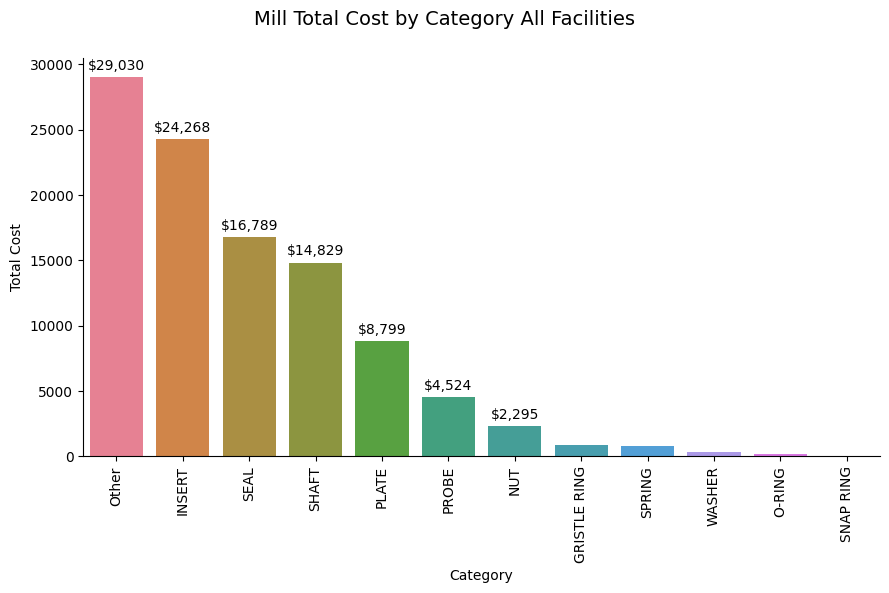

In [ ]:
# Create the catplot
g = sns.catplot(
    x='Mill Part Category',
    y='Total/Base',
    data=grouped_Mill_Category.sort_values('Total/Base', ascending=False),
    kind="bar",
    hue='Mill Part Category',
    height=6,
    aspect=1.5
)

# Rotate x-axis labels
g.set_xticklabels(rotation=90)

# Set axis labels and title using g.set()
g.set_axis_labels("Category", "Total Cost")
g.fig.suptitle('Mill Total Cost by Category All Facilities', fontsize=14)

#############################New Addition############################################
# Add bar labels
for ax in g.axes.flat:
  for container in ax.containers:
    labels = [f'${v.get_height():,.0f}' if v.get_height() > 1000 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding = 3)
####################################################################################

# Adjust layout to prevent title/labels cutoff
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)  # Move title up a bit

# Save the figure with full bounding box
g.fig.savefig('Mill_Total_Cost_by_Category.png', bbox_inches='tight')
plt.show()

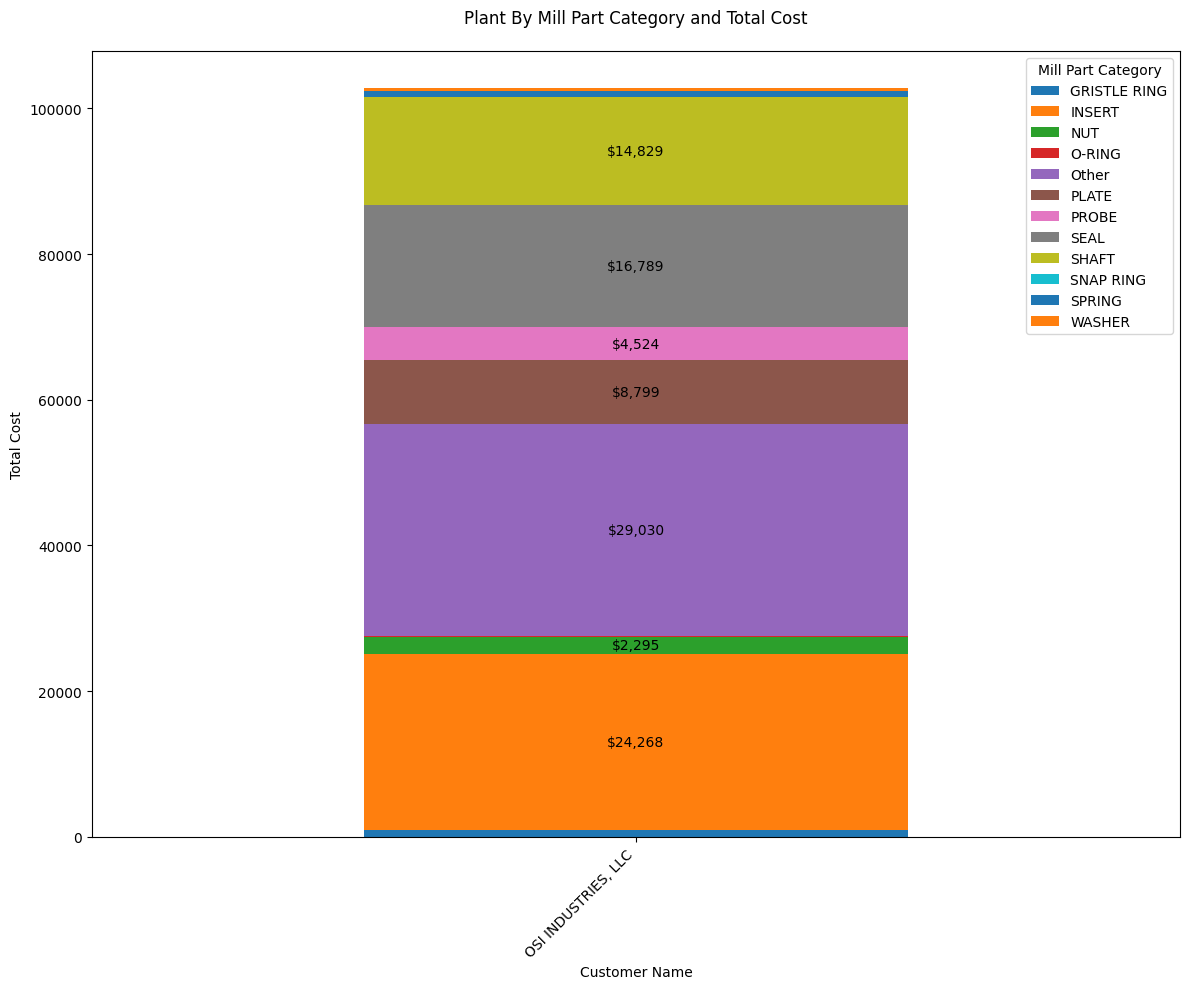

In [ ]:
#plot all bar-S plants by location and spending in each Mill category

# Group the data
grouped_data = dfMillParts.groupby(['Customer Name', 'Mill Part Category'])['Total/Base'].sum().round(2).reset_index()

# Create a stacked bar chart
ax = grouped_data.pivot(index='Customer Name', columns='Mill Part Category', values='Total/Base').plot(
    kind='bar',
    figsize=(12, 10),
    stacked=True
)

# Set title and labels
plt.title('Plant By Mill Part Category and Total Cost', pad=20)
plt.xlabel('Customer Name')
plt.ylabel('Total Cost')
plt.xticks(rotation=45, ha='right')  # Improve readability

# Add bar labels
for c in ax.containers:
    labels = [f'${v.get_height():,.0f}' if v.get_height() > 1000 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

# Adjust layout to prevent cut-off
plt.tight_layout()

# Save the plot with tight bounding box
plt.savefig('Top_Mill_parts_by_Category_and_Factory.png', bbox_inches='tight')
plt.show()

In [ ]:
# @title
###########################No Good########################
# Filter out "Capital" category
df_filtered = df[df["Category"] != "Capital"]

# Group by customer and sort by total cost within each group, selecting the top 10 for each customer
top_ten_parts_per_customer = (
    df_filtered.groupby("Customer Name", group_keys=False)
    .apply(lambda x: x.sort_values(by="Total/Base", ascending=False).head(10))
)

# Display the resulting table
print("Top 10 parts by highest total cost for each customer (excluding Capital category):")
#print(top_ten_parts_per_customer)

top_by_plant = pd.DataFrame(top_ten_parts_per_customer)
len(top_by_plant)
top_by_plant

Top 10 parts by highest total cost for each customer (excluding Capital category):


/tmp/ipython-input-289-903186345.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(by="Total/Base", ascending=False).head(10))


,Order No,Line No,Del No,Status,Order Type,Customer No,Customer Name,Site,Sales Part No,Description,...,Delivery Terms Description,Delivery Leadtime,District Code,Region Code,Originating Del No,Exchange,Cancellation Reason,Cancellation Reason Description,Category Code,Category
15,E6422,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rental Bacon Press 6+ sn 318 Jan 25,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
251,E6539,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rent Bacon Press sn 318 Mar 25,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
153,E6483,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rental Bacon Press 6+ sn 318 Feb25,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
353,E6589,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rental Bacon Press 6+ sn 318 Mar,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
466,E6646,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rent Bacon Press 6+ sn318 May 25,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
725,E6701,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-48100000-1003,Rent Bacon Press 6+ sn318 Jun 25,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
254,E6541,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-53550305,Dieset 66x100 L BP 6+ OSI,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
11,E6421,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-80,Service for BP 6+ (S.No 318) 3/2025,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
469,E6657,2,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,DF-10,Travel Hours,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,DF,Danfotech
299,E6556,1,1,Invoiced/Closed,NOR,95538,OSI Food Solutions Germany GmbH,DFT,FREIGHT,FREIGHT CHARGE,...,EX WORKS,0,Other,GER,Other,ITEM NOT EXCHANGED,Other,Other,FR,Other


#top ten parts-This looks good

In [ ]:
# Group by Customer Name and Sales Part No, then sum the Total/Base
summary = (
    df.groupby(["Customer Name", "Sales Part No"], as_index=False)
    .agg({"Sales Qty": "sum", "Total/Base": "sum"})
)

# Step 2: Extract one Description per Customer + Part combo from the original df
descriptions = (
    df[["Customer Name", "Sales Part No", "Description"]]
    .drop_duplicates(subset=["Customer Name", "Sales Part No"])
)

# Step 3: Merge in the description
summary = summary.merge(descriptions, on=["Customer Name", "Sales Part No"], how="left")

# For each customer, get the top 10 Sales Part Nos based on Total/Base
top_parts_per_customer = (
    summary.groupby("Customer Name", group_keys=False)
           .apply(lambda x: x.nlargest(10, "Total/Base"))
#           .sort_values(["Customer Name", "Total/Base"], ascending=[True, False])
            .reset_index(drop=True)
)

print(type(top_parts_per_customer))

print('Cost of top ten parts $',top_parts_per_customer['Total/Base'].sum())
top_parts_per_customer

<class 'pandas.core.frame.DataFrame'>
Cost of top ten parts $ 2440316.15


/tmp/ipython-input-290-1341913812.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, "Total/Base"))


,Customer Name,Sales Part No,Sales Qty,Total/Base,Description
0,OSI Food Solutions Germany GmbH,DF-48100000-1003,6,408961.27,Rental Bacon Press 6+ sn 318 Jan 25
1,OSI Food Solutions Germany GmbH,DF-53550305,1,46342.40,Dieset 66x100 L BP 6+ OSI
2,OSI Food Solutions Germany GmbH,DF-80,1,35772.50,Service for BP 6+ (S.No 318) 3/2025
3,OSI Food Solutions Germany GmbH,DF-10,18,14299.92,Travel Hours
4,OSI Food Solutions Germany GmbH,FREIGHT,1,11433.25,FREIGHT CHARGE
5,OSI Food Solutions Germany GmbH,DF-20,2,8902.95,Travel Expenses - Flying tickets
6,OSI Food Solutions Germany GmbH,DF-40,3,3269.67,Service Technician
7,OSI Food Solutions Germany GmbH,DF-70,1,590.90,Meals
8,OSI INDUSTRIES LLC,10036,1,401.99,24VDC COIL KIT 1860156
9,OSI INDUSTRIES LLC,70350,72,343.37,TIMING BELT **BY THE INCH**


#Need to look at the above from a overall top 10, no plant breakdown, all of bar-s and compare to total cost of parts

In [ ]:
# Step 1: Group by Sales Part No and sum Sales Qty and Total/Base
summary1 = (
    df.groupby("Sales Part No", as_index=False)
    .agg({"Sales Qty": "sum", "Total/Base": "sum"})
)

# Step 2: Extract one Description per Sales Part No
descriptions1 = df[["Sales Part No", "Description"]].drop_duplicates(subset=["Sales Part No"])

# Step 3: Merge in the description
summary1 = summary1.merge(descriptions1, on="Sales Part No", how="left")

# Step 4: Get top 10 Sales Part Nos based on Total/Base and Sales Qty
# You can sort by both columns if needed, or just Total/Base
top_parts = summary1.sort_values(
    by=["Total/Base", "Sales Qty"], ascending=False
).head(10).reset_index(drop=True)

# Output
print(type(top_parts))
print("Cost of top ten parts $", top_parts["Total/Base"].sum())
top_parts


<class 'pandas.core.frame.DataFrame'>
Cost of top ten parts $ 2200715.85


,Sales Part No,Sales Qty,Total/Base,Description
0,P24138-CCS,1,416725.00,CENTRAL CONTROL SYSTEM
1,DF-48100000-1003,6,408961.27,Rental Bacon Press 6+ sn 318 Jan 25
2,P24138-VS922-9,1,388318.82,"VS922 MULTICUT VAC EMUL SYS, 200HP"
3,DF-835-KIT,2,219352.86,REBUILD KIT FOR 835 LOG PRESS
4,FED_NI_PART_20,15,210686.52,SKID AND CRATE
5,P24138-CSSH2000-10,1,126433.12,"SERVO STUFFING HOPPER, 2000#"
6,FED_BILLSERVICE_20,7,115838.26,SERVICE CHARGE
7,P24108-CVD626-1,1,104800.00,PALLET RETRACT VAT DUMPER
8,P24108-CVD626-2,1,104800.00,PALLET RETRACT VAT DUMPER
9,P24108-CVD626-3,1,104800.00,PALLET RETRACT VAT DUMPER


In [ ]:
save_df_as_excel_table_auto(top_parts, f'top_parts_{most_common_customer}')

✅ Excel file saved to: /content/top_parts_OSI INDUSTRIES, LLC.xlsx


In [ ]:
#test better version of function above
save_df_as_excel_table_auto(top_parts_per_customer, f'top_parts_{most_common_customer}')

✅ Excel file saved to: /content/top_parts_per_customer.xlsx


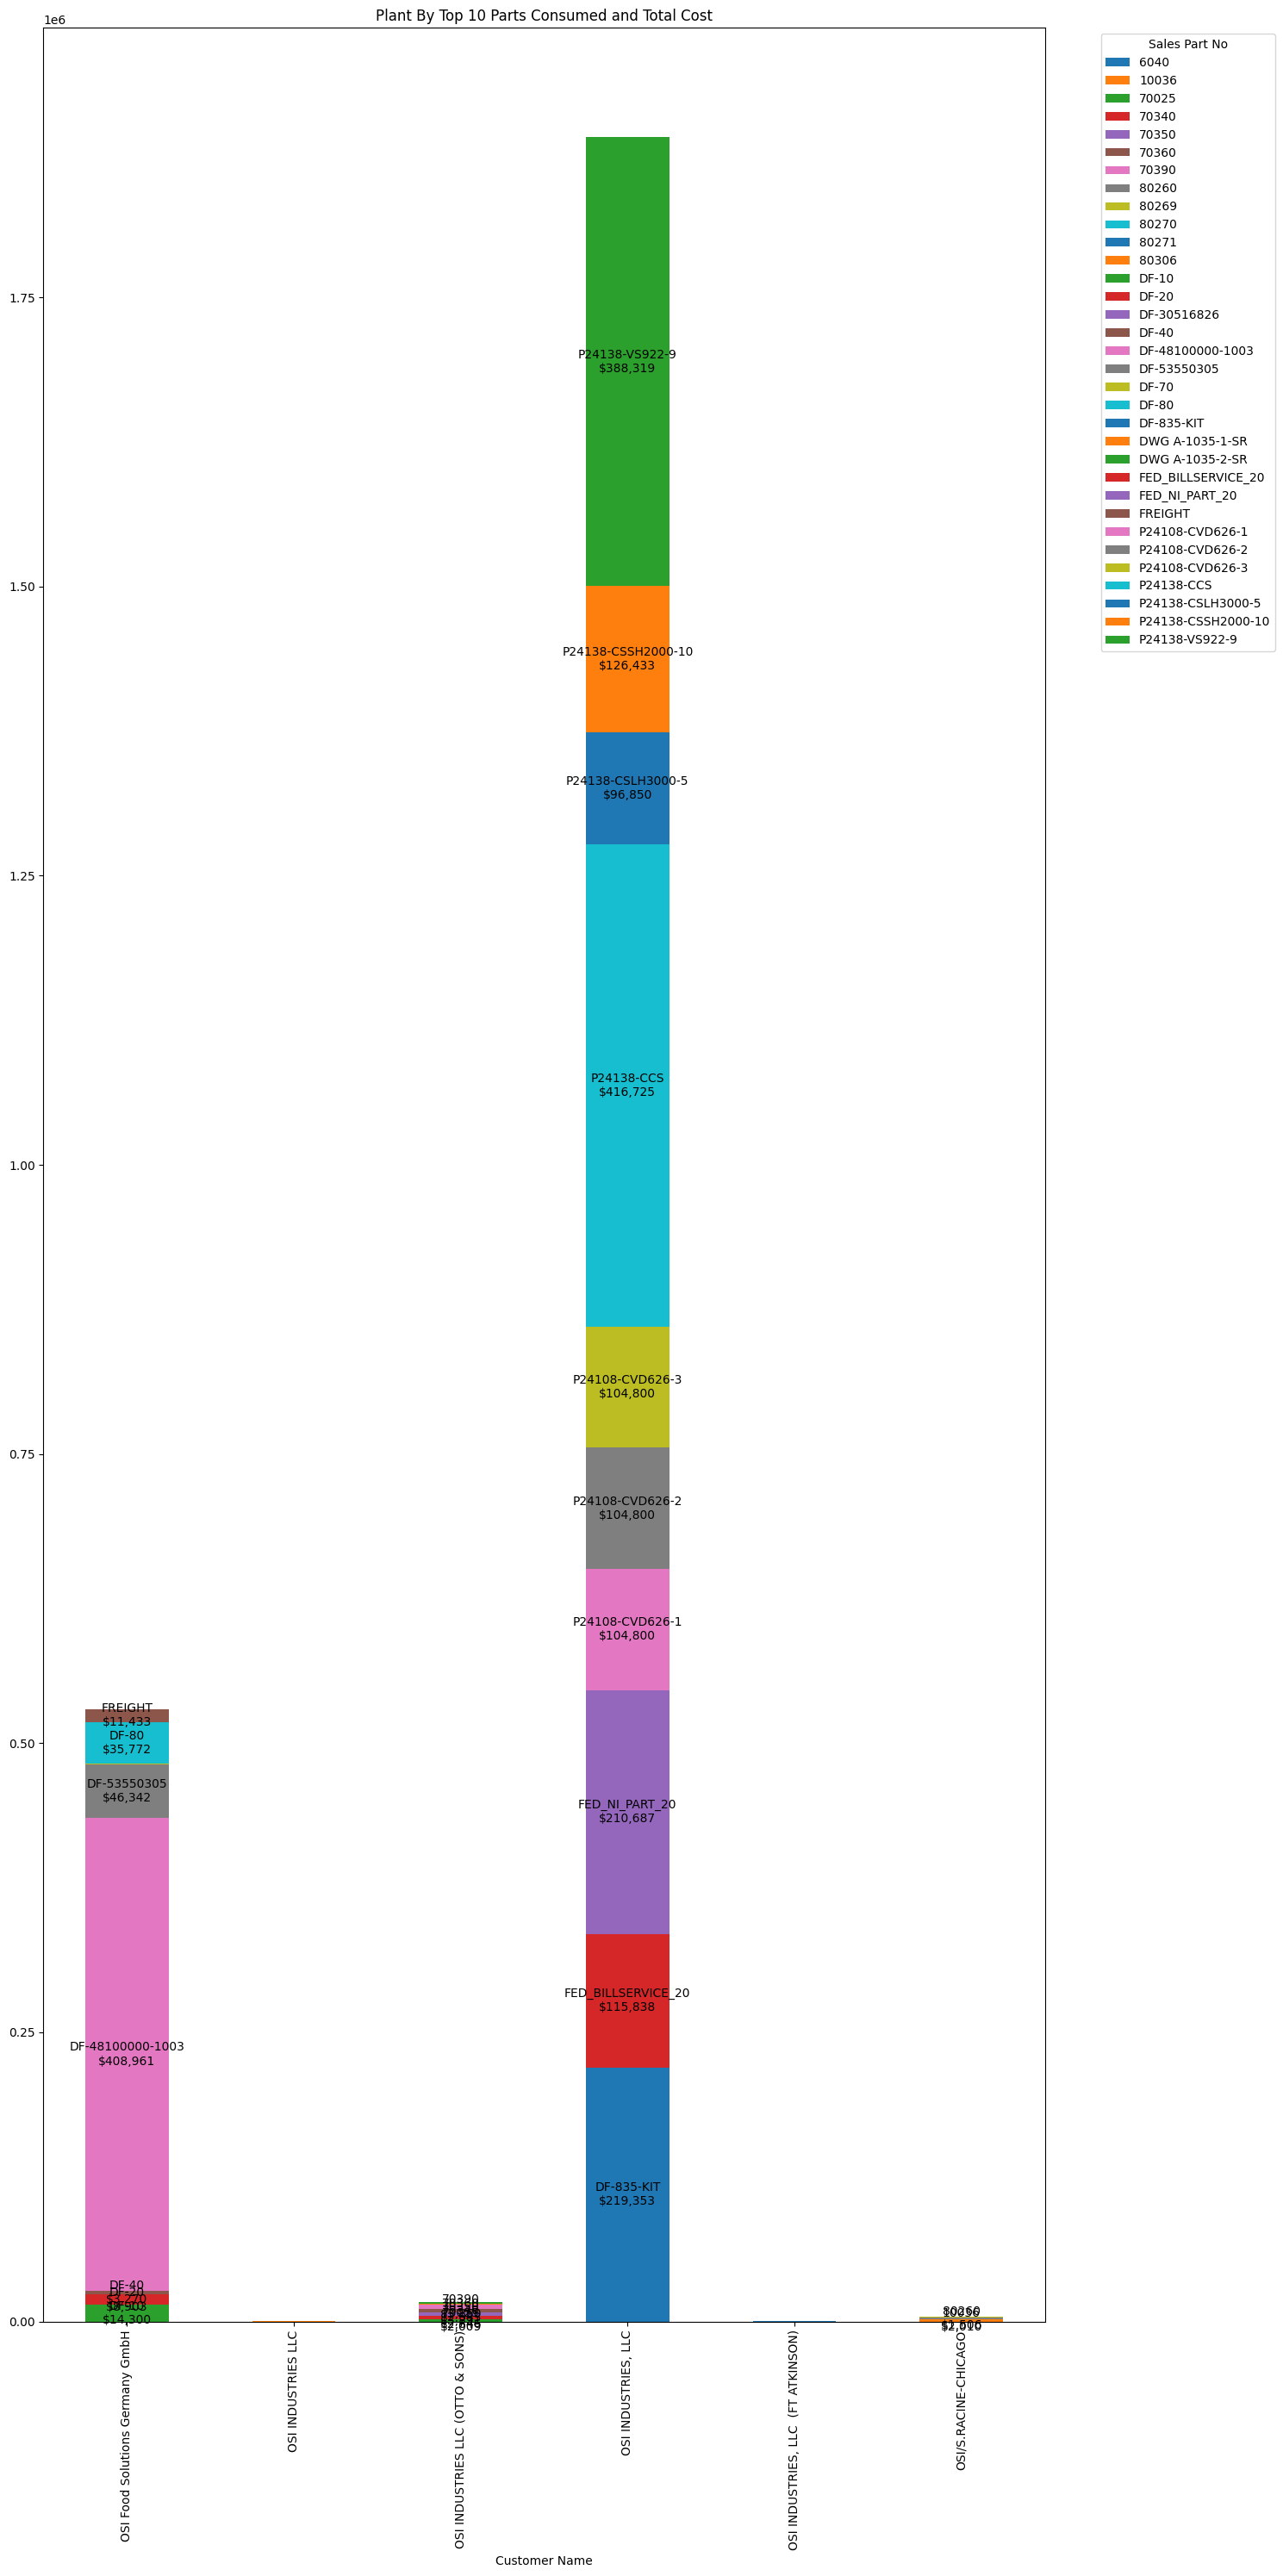

In [ ]:
# @title
# Grouped and pivoted bar chart
grouped_data_top_parts = top_parts_per_customer.groupby(['Customer Name', 'Sales Part No'])['Total/Base'].sum().round(2).reset_index()

pivot_df = grouped_data_top_parts.pivot(index='Customer Name', columns='Sales Part No', values='Total/Base')
ax = pivot_df.plot(kind='bar', figsize=(15,30), stacked=True)
plt.title('Plant By Top 10 Parts Consumed and Total Cost')
plt.legend(title="Sales Part No", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add labels (Sales Part No and $ amount) on the bars
# The order of ax.containers matches the order of pivot_df.columns
for container, part_no in zip(ax.containers, pivot_df.columns):
    labels = [
        f'{part_no}\n${bar.get_height():,.0f}' if bar.get_height() > 1000 else ''
        for bar in container
    ]
    ax.bar_label(container, labels=labels, label_type='center')

plt.tight_layout()

# Save the plot
plt.savefig(f'Top Ten Parts Cost.png')  # Save the figure
plt.show()

#abc analysis and XYZ analysis plus combined

ABC — Based on Total Value (Monetary Importance):
A: Top ~80% of value (high priority)

B: Next ~15% (medium priority)

C: Final ~5% (low priority)

🔤 XYZ — Based on Demand Variability:
X: Very consistent demand (low variation)

Y: Moderate variation

Z: Highly unpredictable demand

🔍 So an AZ item is:
A = Very valuable (generates high revenue or cost impact)

Z = Has erratic, unpredictable demand



In [ ]:
#Add text box for explaining analysis on powerpoint.

#create list and populate with statements.
slide_notes_Parts_Analysis = []
slide_notes_Parts_Analysis.append('ABC — Based on Total Value (Monetary Importance):')
slide_notes_Parts_Analysis.append('')
slide_notes_Parts_Analysis.append('A: Top ~80% of value (high priority)')
slide_notes_Parts_Analysis.append('B: Next ~15% (medium priority)')
slide_notes_Parts_Analysis.append('C: Final ~5% (low priority)')
slide_notes_Parts_Analysis.append('')
slide_notes_Parts_Analysis.append('XYZ — Based on Demand Variability:')
slide_notes_Parts_Analysis.append('')
slide_notes_Parts_Analysis.append('X: Very consistent demand (low variation)')
slide_notes_Parts_Analysis.append('Y: Moderate variation')
slide_notes_Parts_Analysis.append('Z: Highly unpredictable demand')
slide_notes_Parts_Analysis.append('')



In [ ]:
# ---------------------------------------
# ABC ANALYSIS (based on Total/Base value)
# ---------------------------------------
abc_df = df.groupby('Sales Part No')['Total/Base'].sum().reset_index()
abc_df = abc_df.sort_values(by='Total/Base', ascending=False)
abc_df['Cumulative Sum'] = abc_df['Total/Base'].cumsum()
abc_df['Cumulative %'] = 100 * abc_df['Cumulative Sum'] / abc_df['Total/Base'].sum()

def abc_class(row):
    if row['Cumulative %'] <= 80:
        return 'A'
    elif row['Cumulative %'] <= 95:
        return 'B'
    else:
        return 'C'

abc_df['ABC Class'] = abc_df.apply(abc_class, axis=1)

# ---------------------------------------
# XYZ ANALYSIS (based on demand variability)
# ---------------------------------------
xyz_df = df.groupby('Sales Part No')['Sales Qty'].agg(['mean', 'std']).reset_index()
xyz_df['CV'] = xyz_df['std'] / xyz_df['mean']  # Coefficient of Variation

def xyz_class(row):
    if row['CV'] <= 0.1:
        return 'X'
    elif row['CV'] <= 0.25:
        return 'Y'
    else:
        return 'Z'

xyz_df['XYZ Class'] = xyz_df.apply(xyz_class, axis=1)

# ---------------------------------------
# Merge ABC and XYZ
# ---------------------------------------
result = pd.merge(abc_df[['Sales Part No', 'ABC Class']], xyz_df[['Sales Part No', 'XYZ Class']], on='Sales Part No')
result['ABC-XYZ'] = result['ABC Class'] + result['XYZ Class']

# Display result
print(result)

#save to excel
save_df_as_excel_table_auto(result, 'ABC_XYZ_Analysis')

           Sales Part No ABC Class XYZ Class ABC-XYZ
0             P24138-CCS         A         Z      AZ
1       DF-48100000-1003         A         X      AX
2         P24138-VS922-9         A         Z      AZ
3             DF-835-KIT         A         X      AX
4         FED_NI_PART_20         A         X      AX
..                   ...       ...       ...     ...
363   07-FLO-4864-VFDAMD         C         X      CX
364  07-FLO-500323CFF-28         C         X      CX
365     07-FLO-3339FFF-3         C         X      CX
366       11-008-3036-NN         C         Z      CZ
367     P24138-CP-12-ALT         C         Z      CZ

[368 rows x 4 columns]
✅ Excel file saved to: /content/ABC_XYZ_Analysis.xlsx


In [ ]:
%%script echo skipping
import pandas as pd

#use original data frame df for analysis

# Extract part numbers
part_numbers = df['Sales Part No']

# Extract only monthly demand columns
monthly_data = df.drop(columns=['Sales Part No'])

print(monthly_data)

# Calculate total annual demand
df['Annual_Demand'] = monthly_data.sum(axis=1)

# ABC classification based on annual demand
df = df.sort_values('Annual_Demand', ascending=False)
df['Cumulative_Demand'] = df['Annual_Demand'].cumsum()
total_demand = df['Annual_Demand'].sum()
df['Cumulative_%'] = df['Cumulative_Demand'] / total_demand

def abc_class(cum_pct):
    if cum_pct <= 0.8:
        return 'A'
    elif cum_pct <= 0.95:
        return 'B'
    else:
        return 'C'

df['ABC_Class'] = df['Cumulative_%'].apply(abc_class)

# XYZ classification based on demand variability (Coefficient of Variation)
df['Mean_Monthly'] = monthly_data.mean(axis=1)
df['Std_Monthly'] = monthly_data.std(axis=1)
df['CV'] = df['Std_Monthly'] / df['Mean_Monthly'].replace(0, 0.0001)  # avoid divide-by-zero

def xyz_class(cv):
    if cv < 0.5:
        return 'X'
    elif cv < 1.0:
        return 'Y'
    else:
        return 'Z'

df['XYZ_Class'] = df['CV'].apply(xyz_class)

# Final classification: Combine ABC and XYZ
df['ABC_XYZ'] = df['ABC_Class'] + df['XYZ_Class']

# Reorder and output
output_columns = ['Sales Part No', 'Annual_Demand', 'ABC_Class', 'CV', 'XYZ_Class', 'ABC_XYZ']
result = df[output_columns]
print(result)

# Optional: Save to Excel
result.to_excel("abc_xyz_classification.xlsx", index=False)

skipping


#Create powerpoint

In [ ]:
#####################Need to update for excel table to fit on one slide, formatting issue, otherwise good.
# Configuration
image_folder = '/content/'
output_pptx = 'Parts Consumption Breakdown.pptx'
company_name = 'Cozzini, Inc.'
logo_path = '/content/COZZINI FOOD EQUIPMENT.png'
logo_filename = os.path.basename(logo_path).lower()
max_table_rows = 50  # Preview only top 10 rows
#template_path = '/content/custom_template.pptx'

# Create presentation
prs = Presentation()
prs.slide_width = Inches(10)
prs.slide_height = Inches(7.5)

# --- Title Slide ---
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = f"Parts Consumption Report for {most_common_customer}"

#######################Need to automate date statement##################################
slide.placeholders[1].text = f"from {min_date} to {max_date}"
########################################################################################

# --- Company Slide ---
company_slide = prs.slides.add_slide(prs.slide_layouts[5])
company_slide.shapes.title.text = company_name
if os.path.exists(logo_path):
    company_slide.shapes.add_picture(logo_path, Inches(3.5), Inches(2),
                                     width=Inches(3), height=Inches(2))
textbox = company_slide.shapes.add_textbox(Inches(1), Inches(4.5), Inches(8), Inches(2))
tf = textbox.text_frame
tf.text = "Prepared by: Automation Script\nDate: June 2025"
for paragraph in tf.paragraphs:
    for run in paragraph.runs:
        run.font.size = Pt(18)
        run.font.color.rgb = RGBColor(80, 80, 80)

# --- PNG Slides (skip logo) ---
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith('.png') and filename.lower() != logo_filename:
        img_path = os.path.join(image_folder, filename)
        slide = prs.slides.add_slide(prs.slide_layouts[6])
        slide.shapes.add_picture(img_path, Inches(0), Inches(0),
                                 width=prs.slide_width, height=prs.slide_height)

# --- Excel Table Slides ---
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.xls', '.xlsx')) and filename.lower() != 'compiled.xlsx':
        filepath = os.path.join(image_folder, filename)
        try:
            df = pd.read_excel(filepath)
            df = df.fillna('')  # Fill NaNs for display
            df_preview = df.head(max_table_rows)

            # Add slide
            slide = prs.slides.add_slide(prs.slide_layouts[5])

            ################################################
            ##  Change the below to have better formatting on name of slide
            # Replace underscores with spaces and remove the .xlsx extension
            clean_name = filename.replace('_', ' ').removesuffix('.xlsx')
            slide.shapes.title.text = f"{clean_name}"
            ##################################################

            # Add table
            rows, cols = df_preview.shape
            table = slide.shapes.add_table(rows + 1, cols, Inches(0.5), Inches(1.5), Inches(9), Inches(5)).table

            # Set column headers
            for col_idx, col_name in enumerate(df_preview.columns):
                cell = table.cell(0, col_idx)
                cell.text = str(col_name)
                cell.text_frame.paragraphs[0].font.size = Pt(12)
                cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

            # Set cell values
            for row_idx, row in df_preview.iterrows():
                for col_idx, value in enumerate(row):
                    cell = table.cell(row_idx + 1, col_idx)

                   # Format based on type
                    if isinstance(value, float):
                      formatted_value = f"${value:,.2f}" if col_idx == 2 else f"{value:,.2f}"
                    elif isinstance(value, int):
                      formatted_value = f"{value:,}"
                    elif isinstance(value, datetime):
                      formatted_value = value.strftime("%Y-%m-%d")
                    else:
                      formatted_value = str(value)

                  # Apply to PowerPoint cell
                    cell.text = formatted_value
                    cell.text_frame.paragraphs[0].font.size = Pt(11)

        except Exception as e:
            print(f"❌ Could not read {filename}: {e}")
            continue

# --- Add Slide with Notes --- for text box on overall spend.

# Add last slide
final_slide = prs.slides.add_slide(prs.slide_layouts[5])
final_slide.shapes.title.text = "Overall Spend Analysis"

# Add text box for notes regarding annual projections and % of ownership
left = Inches(1)
top = Inches(1.5)
width = Inches(8)
height = Inches(4.5)
textbox = final_slide.shapes.add_textbox(left, top, width, height)
text_frame = textbox.text_frame
text_frame.word_wrap = True

# Add notes to text box
for line in slide_notes:
    p = text_frame.add_paragraph()
    p.text = line
    p.font.size = Pt(16)
    p.alignment = PP_ALIGN.LEFT

# Add last slide for Parts Analysis
final_slide1 = prs.slides.add_slide(prs.slide_layouts[5])
final_slide1.shapes.title.text = "ABC & XYZ Parts Analysis"

# Add text box for ABC analysis
left = Inches(1)
top = Inches(1.5)
width = Inches(8)
height = Inches(4.5)
textbox = final_slide1.shapes.add_textbox(left, top, width, height)
text_frame = textbox.text_frame
text_frame.word_wrap = True

# Add notes to text box for parts analysis wording
for line in slide_notes_Parts_Analysis:
    p = text_frame.add_paragraph()
    p.text = line
    p.font.size = Pt(16)
    p.alignment = PP_ALIGN.LEFT

# Save PPT
prs.save(output_pptx)
print(f"✅ Presentation saved as: {output_pptx}")

✅ Presentation saved as: Parts Consumption Breakdown.pptx
